# Optimal Transport
## *Project: OT GAN*

# Import

First let's import some packages that we'll need throughout the notebook

In [ ]:
import tensorflow as tf
import numpy as np

# Let's check for the GPU
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6410701629250519558, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15703311680
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15757125998230118086
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

# MNIST Data

We will only use the 60k in the train dataset

In [ ]:
(x, _), (_, _) = tf.keras.datasets.mnist.load_data()

We resize the image to the 64 x 64 format

In [ ]:
from skimage.transform import resize
images = resize(x, (x.shape[0], 64, 64, 1), preserve_range=True).astype("float32")

The images also need to be normalized

In [ ]:
images = (images - 127.5) / 127.5

Let's see the shape of these images

In [ ]:
images.shape

(60000, 64, 64, 1)

# Model

In this OT GAN model we need to define a generator and a discriminator/critic

## Critic

First let's build our discriminator. Our input is of size 64 x 64. With a kernel size of 5, a  stride of 2 and a padding "same" the first convolutional layer output an image of size 32 x 32. The start padding is of size:

$$
P_{start} =
\left \lfloor{
\frac{
    2 \left \lceil{\frac{64}{2}} \right \rceil -64 + 5 - 2
}{2}
}\right \rfloor
= 
\left \lfloor{
    \frac{3}{2}
}\right \rfloor
= 1
$$

and the end padding:

$$
P_{end} =
\left \lceil{
\frac{
    2 \left \lceil{\frac{64}{2}} \right \rceil -64 + 5 - 2
}{2}
}\right \rceil
= 
\left \lceil{
    \frac{3}{2}
}\right \rceil
= 2
$$

which gives an ouptut size:

$$
O = \frac{64 - 5 +1 + 2}{2} + 1 = 32
$$

Same goes for each convolutional layer: the output gets divided by 2 at each step.

In [ ]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Flatten, Input, LeakyReLU, Dense

def critic():
    input_image = Input(shape=(64, 64, 1))

    x = Conv2D(64,
                      (5, 5),
                      strides=(2, 2),
                      padding='same',
                      kernel_initializer=initializer)(input_image)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128,
                      (5, 5),
                      strides=(2, 2),
                      padding='same',
                      kernel_initializer=initializer)(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256,
                      (5, 5),
                      strides=(2, 2),
                      padding='same',
                      kernel_initializer=initializer)(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512,
                      (5, 5),
                      strides=(3, 3),
                      padding='valid',
                      kernel_initializer=initializer)(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = tf.math.l2_normalize(x)

    return Model(inputs=input_image, outputs=x)

critic = critic()

critic.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 8, 8, 256)         0  

## Generator

Then let's build our generator. The input is a random vector $z$ of size 2048 (to match the output of the critic) and we only use transpose convolutional layers. The dimension of the output doubles at each layer until it reaches 64 x 64 which is the original image size.

In [ ]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Flatten, Input, LeakyReLU, Dense
from tensorflow.keras import initializers
from tensorflow.keras.models import Model

initializer = initializers.GlorotUniform()

def generator():
    input_noise = Input(shape=(1, 1, 2048))

    x = Conv2DTranspose(512,
                        kernel_size=4,
                        strides=1,
                        padding="valid",
                        kernel_initializer=initializer)(input_noise)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(256,
                        kernel_size=5,
                        strides=2,
                        padding="same",
                        kernel_initializer=initializer)(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(128,
                        kernel_size=5,
                        strides=2,
                        padding="same",
                        kernel_initializer=initializer)(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(128,
                        kernel_size=5,
                        strides=2,
                        padding="same",
                        kernel_initializer=initializer)(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(1,
                        kernel_size=5,
                        strides=2,
                        padding="same",
                        activation="tanh",
                        kernel_initializer=initializer)(x)


    return Model(inputs=input_noise, outputs=x)

generator = generator()

generator.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 1, 1, 2048)]      0         
_________________________________________________________________
conv2d_transpose_30 (Conv2DT (None, 4, 4, 512)         16777728  
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_31 (Conv2DT (None, 8, 8, 256)         3277056   
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_32 (Conv2DT (None, 16, 16, 128)       819328    
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 16, 16, 128)       0  

## Wasserstein distance

Now let's define our Wasserstein distance

In [ ]:
# Test cell
batch_size = 200

X = images[:batch_size]
batch_x = critic(X, training=False)

y = tf.random.normal(shape=(batch_size,1,1,2048))
Y = generator(y, training=False)
batch_y = critic(Y, training=False)

batch_x.shape, batch_y.shape

(TensorShape([200, 2048]), TensorShape([200, 2048]))

Our cost function is define based on the cosine similarity :

$$
c_{\eta}(\mathbf{x}, \mathbf{y})=1-\frac{v_{\eta}(\mathbf{x}) \cdot v_{\eta}(\mathbf{y})}{\left\|v_{\eta}(\mathbf{x})\right\|_{2}\left\|v_{\eta}(\mathbf{y})\right\|_{2}}
$$

In [ ]:
def cost_function(batch_x, batch_y):
    # Cosine similarity
    similarity = tf.reduce_sum(batch_x[:, tf.newaxis] * batch_y, axis=-1)
    similarity /= (tf.norm(batch_x[:, tf.newaxis], axis=-1) * tf.norm(batch_y, axis=-1) +1e-12)
    # Computing the distance
    distance = 1 - similarity
    return distance

In [ ]:
cost_function(batch_x, batch_y)

<tf.Tensor: shape=(200, 200), dtype=float32, numpy=
array([[0.55971295, 0.5540311 , 0.54773045, ..., 0.54987204, 0.5585832 ,
        0.5661042 ],
       [0.5421903 , 0.53892285, 0.52748185, ..., 0.52407295, 0.54388505,
        0.53693056],
       [0.5532329 , 0.5473745 , 0.56350243, ..., 0.53274554, 0.563089  ,
        0.569111  ],
       ...,
       [0.5557072 , 0.553432  , 0.5462569 , ..., 0.55151135, 0.55310714,
        0.5542513 ],
       [0.5491655 , 0.56722057, 0.5441415 , ..., 0.53670955, 0.5723935 ,
        0.5725874 ],
       [0.5292311 , 0.54098547, 0.5589187 , ..., 0.52828515, 0.54509336,
        0.5468013 ]], dtype=float32)>

Now that we have our cost matrices we can run the Sinkhorn algorithm :

In [ ]:
def sinkhorn(C, batch_size, epsilon=0.1, max_iters=100, delta = 1e-3):
    # Computing the kernel matrix
    K = tf.math.exp(-C/epsilon)
    a = tf.ones(batch_size)
    b = tf.ones(batch_size)
    # Alternate projections
    v = tf.ones(b.shape[0])
    for _ in range(max_iters):
        u = tf.divide(a, tf.linalg.matvec(K, v))
        v = tf.divide(b, tf.linalg.matvec(K, u))
    diag_u = tf.linalg.diag(tf.reshape(u, shape=b.shape[0]))
    diag_v = tf.linalg.diag(tf.reshape(v, shape=b.shape[0]))
    # Returning the soft matching
    return tf.linalg.matmul(tf.linalg.matmul(diag_u, K), diag_v)

# Training

In [ ]:
def train_OTGAN(X1, X2, update_gen=False):
    batch_size = X1.shape[0]

    # Recording all the operations for the gradient computing
    with tf.GradientTape(persistent=True) as tape:

        # Generating the random noise
        y1 = tf.random.uniform(shape=(batch_size,1,1,2048), minval=-1, maxval=1)
        y2 = tf.random.uniform(shape=(batch_size,1,1,2048), minval=-1, maxval=1)

        # Generating the fake images from the noise
        Y1 = generator(y1, training=True)
        Y2 = generator(y2, training=True)

        # Getting the latent vectors from the critic
        batch_x1 = critic(X1, training=True)
        batch_x2 = critic(X2, training=True)
        batch_y1 = critic(Y1, training=True)
        batch_y2 = critic(Y1, training=True)

        # Computing the cost matrices for each couple
        C_x1_y1 = cost_function(batch_x1, batch_y1) 
        C_x1_y2 = cost_function(batch_x1, batch_y2) 
        C_x2_y1 = cost_function(batch_x2, batch_y1) 
        C_x2_y2 = cost_function(batch_x2, batch_y2) 
        C_x1_x2 = cost_function(batch_x1, batch_x2)
        C_y1_y2 = cost_function(batch_y1, batch_y2)

        # Getting the soft matching of each couple
        M_x1_y1 = sinkhorn(C_x1_y1, batch_size)
        M_x1_y2 = sinkhorn(C_x1_y2, batch_size)
        M_x2_y1 = sinkhorn(C_x2_y1, batch_size)
        M_x2_y2 = sinkhorn(C_x2_y2, batch_size)
        M_x1_x2 = sinkhorn(C_x1_x2, batch_size)
        M_y1_y2 = sinkhorn(C_y1_y2, batch_size)

        # Finally getting the loss
        loss_x1_y1 = tf.linalg.trace(tf.matmul(M_x1_y1, tf.transpose(C_x1_y1)))
        loss_x1_y2 = tf.linalg.trace(tf.matmul(M_x1_y2, tf.transpose(C_x1_y2)))
        loss_x2_y1 = tf.linalg.trace(tf.matmul(M_x2_y1, tf.transpose(C_x2_y1)))
        loss_x2_y2 = tf.linalg.trace(tf.matmul(M_x2_y2, tf.transpose(C_x2_y2)))
        loss_x1_x2 = tf.linalg.trace(tf.matmul(M_x1_x2, tf.transpose(C_x1_x2)))
        loss_y1_y2 = tf.linalg.trace(tf.matmul(M_y1_y2, tf.transpose(C_y1_y2)))

        # Computing the losses
        loss_critic = 2*loss_x1_x2 + 2*loss_y1_y2
        loss_generator = loss_x1_y1 + loss_x1_y2 + loss_x2_y1 + loss_x2_y2
        total_loss = loss_generator - loss_critic
    
    # Updating the generator gradients when needed
    if update_gen==True:
        grads_generator = tape.gradient(total_loss, generator.trainable_variables)
        optimizer_g.apply_gradients(zip(grads_generator, generator.trainable_variables))

    # Updating the critic gradients
    grads_critic = -1 * tape.gradient(total_loss, critic.trainable_variables)
    optimizer_c.apply_gradients(zip(grads_critic, critic.trainable_variables))

    return total_loss, loss_critic, loss_generator

In [ ]:
import matplotlib.pyplot as plt

# Function to display the outputs of the generator throughout training
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

====== Epoch  0 ======
0 ... 
Total Loss : 233.25289916992188
Loss Critic : 201.88232421875
Loss Generator : 435.1352233886719
1 ... 
Total Loss : 233.948974609375
Loss Critic : 201.09625244140625
Loss Generator : 435.04522705078125
2 ... 
Total Loss : 233.50668334960938
Loss Critic : 200.88882446289062
Loss Generator : 434.3955078125
3 ... 
Total Loss : 234.35855102539062
Loss Critic : 202.60540771484375
Loss Generator : 436.9639587402344
4 ... 
Total Loss : 212.39462280273438
Loss Critic : 95.74153900146484
Loss Generator : 308.13616943359375
5 ... 
Total Loss : 212.250732421875
Loss Critic : 98.10324096679688
Loss Generator : 310.3539733886719


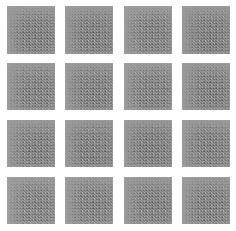

6 ... 
Total Loss : 211.898681640625
Loss Critic : 97.09680938720703
Loss Generator : 308.9954833984375
7 ... 
Total Loss : 167.3367919921875
Loss Critic : 96.11773681640625
Loss Generator : 263.45452880859375
8 ... 
Total Loss : 167.89450073242188
Loss Critic : 94.82857513427734
Loss Generator : 262.72308349609375
9 ... 
Total Loss : 167.0879669189453
Loss Critic : 95.16236877441406
Loss Generator : 262.2503356933594
10 ... 
Total Loss : 145.80929565429688
Loss Critic : 97.05443572998047
Loss Generator : 242.8637237548828


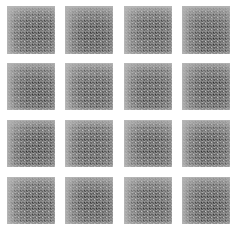

11 ... 
Total Loss : 146.18435668945312
Loss Critic : 96.53333282470703
Loss Generator : 242.71768188476562
12 ... 
Total Loss : 144.04078674316406
Loss Critic : 95.8861083984375
Loss Generator : 239.92689514160156
13 ... 
Total Loss : 128.89132690429688
Loss Critic : 94.4693603515625
Loss Generator : 223.36068725585938
14 ... 
Total Loss : 129.69540405273438
Loss Critic : 94.39893341064453
Loss Generator : 224.09432983398438
15 ... 
Total Loss : 128.94984436035156
Loss Critic : 95.05271911621094
Loss Generator : 224.0025634765625


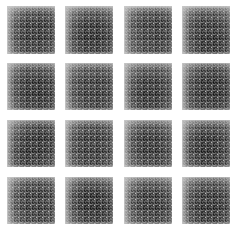

16 ... 
Total Loss : 114.25090789794922
Loss Critic : 94.13907623291016
Loss Generator : 208.38998413085938
17 ... 
Total Loss : 115.56114959716797
Loss Critic : 97.95783233642578
Loss Generator : 213.51898193359375
18 ... 
Total Loss : 115.83680725097656
Loss Critic : 94.54586791992188
Loss Generator : 210.38267517089844
19 ... 
Total Loss : 102.72572326660156
Loss Critic : 95.4388427734375
Loss Generator : 198.16456604003906
20 ... 
Total Loss : 99.07979583740234
Loss Critic : 94.74556732177734
Loss Generator : 193.8253631591797


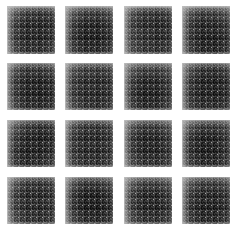

21 ... 
Total Loss : 102.489501953125
Loss Critic : 94.72993469238281
Loss Generator : 197.2194366455078
22 ... 
Total Loss : 92.50730895996094
Loss Critic : 96.77882385253906
Loss Generator : 189.2861328125
23 ... 
Total Loss : 93.68949127197266
Loss Critic : 94.4618911743164
Loss Generator : 188.15138244628906
24 ... 
Total Loss : 89.10669708251953
Loss Critic : 93.6612777709961
Loss Generator : 182.76797485351562
25 ... 
Total Loss : 84.89900970458984
Loss Critic : 95.77066802978516
Loss Generator : 180.669677734375


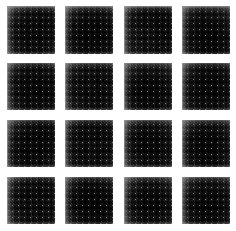

26 ... 
Total Loss : 83.35905456542969
Loss Critic : 94.5673828125
Loss Generator : 177.9264373779297
27 ... 
Total Loss : 83.76869201660156
Loss Critic : 95.55424499511719
Loss Generator : 179.32293701171875
28 ... 
Total Loss : 78.59941864013672
Loss Critic : 94.8320541381836
Loss Generator : 173.4314727783203
29 ... 
Total Loss : 79.18797302246094
Loss Critic : 96.25343322753906
Loss Generator : 175.44140625
30 ... 
Total Loss : 82.69271850585938
Loss Critic : 95.83883666992188
Loss Generator : 178.53155517578125


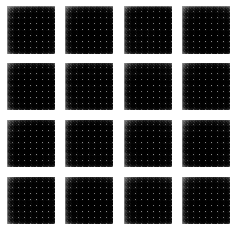

31 ... 
Total Loss : 78.83418273925781
Loss Critic : 95.32279968261719
Loss Generator : 174.156982421875
32 ... 
Total Loss : 79.6519775390625
Loss Critic : 96.4766845703125
Loss Generator : 176.128662109375
33 ... 
Total Loss : 78.32646179199219
Loss Critic : 95.18112182617188
Loss Generator : 173.50758361816406
34 ... 
Total Loss : 77.76029968261719
Loss Critic : 95.50894165039062
Loss Generator : 173.2692413330078
35 ... 
Total Loss : 75.66815185546875
Loss Critic : 94.09727478027344
Loss Generator : 169.7654266357422


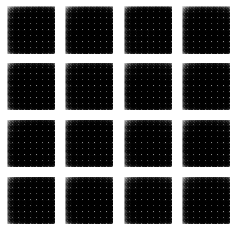

36 ... 
Total Loss : 76.17412567138672
Loss Critic : 94.43262481689453
Loss Generator : 170.60675048828125
37 ... 
Total Loss : 77.916015625
Loss Critic : 95.01751708984375
Loss Generator : 172.93353271484375
38 ... 
Total Loss : 76.08880615234375
Loss Critic : 93.3402099609375
Loss Generator : 169.42901611328125
39 ... 
Total Loss : 78.60155487060547
Loss Critic : 96.13753509521484
Loss Generator : 174.7390899658203
40 ... 
Total Loss : 76.50836944580078
Loss Critic : 96.53771209716797
Loss Generator : 173.04608154296875


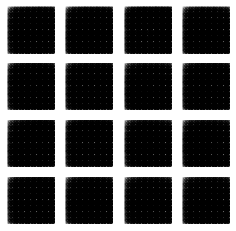

41 ... 
Total Loss : 78.4244613647461
Loss Critic : 95.59931182861328
Loss Generator : 174.02377319335938
42 ... 
Total Loss : 78.77246856689453
Loss Critic : 96.12097930908203
Loss Generator : 174.89344787597656
43 ... 
Total Loss : 75.73219299316406
Loss Critic : 94.27848815917969
Loss Generator : 170.01068115234375
44 ... 
Total Loss : 77.04766082763672
Loss Critic : 95.43209075927734
Loss Generator : 172.47975158691406
45 ... 
Total Loss : 77.35244750976562
Loss Critic : 95.46722412109375
Loss Generator : 172.81967163085938


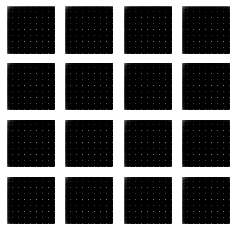

46 ... 
Total Loss : 75.31063079833984
Loss Critic : 94.7423324584961
Loss Generator : 170.05296325683594
47 ... 
Total Loss : 74.8890609741211
Loss Critic : 94.6791000366211
Loss Generator : 169.5681610107422
48 ... 
Total Loss : 75.97896575927734
Loss Critic : 94.95633697509766
Loss Generator : 170.935302734375
49 ... 
Total Loss : 74.03199768066406
Loss Critic : 92.83421325683594
Loss Generator : 166.8662109375
50 ... 
Total Loss : 76.24958038330078
Loss Critic : 94.52201080322266
Loss Generator : 170.77159118652344


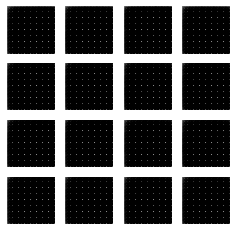

51 ... 
Total Loss : 78.78312683105469
Loss Critic : 92.86552429199219
Loss Generator : 171.64865112304688
52 ... 
Total Loss : 76.12980651855469
Loss Critic : 96.34629821777344
Loss Generator : 172.47610473632812
53 ... 
Total Loss : 77.67464447021484
Loss Critic : 95.03385162353516
Loss Generator : 172.70849609375
54 ... 
Total Loss : 77.13772583007812
Loss Critic : 95.78071594238281
Loss Generator : 172.91844177246094
55 ... 
Total Loss : 73.99632263183594
Loss Critic : 94.95845031738281
Loss Generator : 168.95477294921875


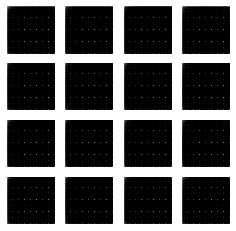

56 ... 
Total Loss : 75.23417663574219
Loss Critic : 96.93534851074219
Loss Generator : 172.16952514648438
57 ... 
Total Loss : 76.618408203125
Loss Critic : 96.39390563964844
Loss Generator : 173.01231384277344
58 ... 
Total Loss : 79.4678955078125
Loss Critic : 95.02622985839844
Loss Generator : 174.49412536621094
59 ... 
Total Loss : 79.12513732910156
Loss Critic : 96.63136291503906
Loss Generator : 175.75650024414062
60 ... 
Total Loss : 72.37692260742188
Loss Critic : 94.04515075683594
Loss Generator : 166.4220733642578


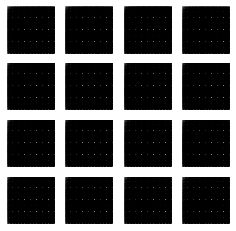

61 ... 
Total Loss : 77.24149322509766
Loss Critic : 94.05469512939453
Loss Generator : 171.2961883544922
62 ... 
Total Loss : 77.27520751953125
Loss Critic : 94.77841186523438
Loss Generator : 172.05361938476562
63 ... 
Total Loss : 77.50584411621094
Loss Critic : 95.72178649902344
Loss Generator : 173.22763061523438
64 ... 
Total Loss : 73.11897277832031
Loss Critic : 94.21348571777344
Loss Generator : 167.33245849609375
65 ... 
Total Loss : 73.93148040771484
Loss Critic : 94.06897735595703
Loss Generator : 168.00045776367188


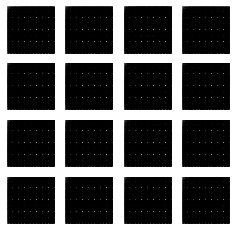

66 ... 
Total Loss : 75.30750274658203
Loss Critic : 94.80689239501953
Loss Generator : 170.11439514160156
67 ... 
Total Loss : 75.15211486816406
Loss Critic : 95.78074645996094
Loss Generator : 170.932861328125
68 ... 
Total Loss : 77.77159881591797
Loss Critic : 95.11783599853516
Loss Generator : 172.88943481445312
69 ... 
Total Loss : 75.61394500732422
Loss Critic : 94.77783966064453
Loss Generator : 170.39178466796875
70 ... 
Total Loss : 77.14495086669922
Loss Critic : 96.2927017211914
Loss Generator : 173.43765258789062


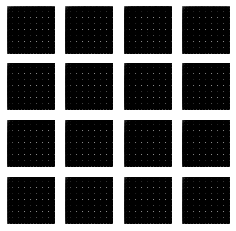

71 ... 
Total Loss : 73.72960662841797
Loss Critic : 95.18146514892578
Loss Generator : 168.91107177734375
72 ... 
Total Loss : 76.62097930908203
Loss Critic : 94.45455169677734
Loss Generator : 171.07553100585938
73 ... 
Total Loss : 77.62897491455078
Loss Critic : 93.42134857177734
Loss Generator : 171.05032348632812
74 ... 
Total Loss : 75.21720123291016
Loss Critic : 95.03343963623047
Loss Generator : 170.25064086914062
75 ... 
Total Loss : 75.88301849365234
Loss Critic : 95.9645767211914
Loss Generator : 171.84759521484375


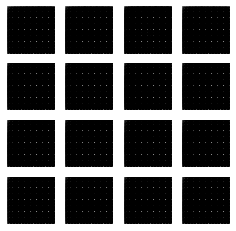

76 ... 
Total Loss : 76.35419464111328
Loss Critic : 94.54088592529297
Loss Generator : 170.89508056640625
77 ... 
Total Loss : 75.12693786621094
Loss Critic : 95.28153991699219
Loss Generator : 170.40847778320312
78 ... 
Total Loss : 76.71128845214844
Loss Critic : 94.50424194335938
Loss Generator : 171.2155303955078
79 ... 
Total Loss : 75.03953552246094
Loss Critic : 96.22305297851562
Loss Generator : 171.26258850097656
80 ... 
Total Loss : 77.79798889160156
Loss Critic : 96.33644104003906
Loss Generator : 174.13442993164062


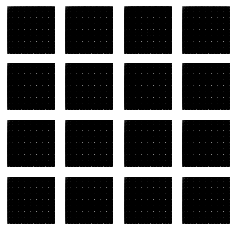

81 ... 
Total Loss : 74.80760192871094
Loss Critic : 96.46046447753906
Loss Generator : 171.26806640625
82 ... 
Total Loss : 76.27738189697266
Loss Critic : 94.4438705444336
Loss Generator : 170.72125244140625
83 ... 
Total Loss : 75.46439361572266
Loss Critic : 96.29509735107422
Loss Generator : 171.75949096679688
84 ... 
Total Loss : 78.35025787353516
Loss Critic : 97.10576629638672
Loss Generator : 175.45602416992188
85 ... 
Total Loss : 75.59992218017578
Loss Critic : 95.2085189819336
Loss Generator : 170.80844116210938


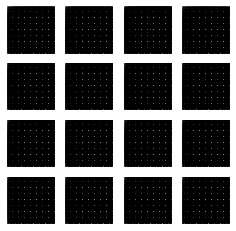

86 ... 
Total Loss : 74.79441833496094
Loss Critic : 95.75112915039062
Loss Generator : 170.54554748535156
87 ... 
Total Loss : 76.0252914428711
Loss Critic : 96.08574676513672
Loss Generator : 172.1110382080078
88 ... 
Total Loss : 75.27992248535156
Loss Critic : 95.01826477050781
Loss Generator : 170.29818725585938
89 ... 
Total Loss : 72.49466705322266
Loss Critic : 95.13936614990234
Loss Generator : 167.634033203125
90 ... 
Total Loss : 75.5074691772461
Loss Critic : 97.28754425048828
Loss Generator : 172.79501342773438


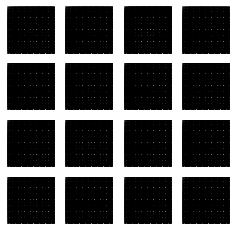

91 ... 
Total Loss : 75.54129791259766
Loss Critic : 96.13333892822266
Loss Generator : 171.6746368408203
92 ... 
Total Loss : 73.79460144042969
Loss Critic : 95.05744934082031
Loss Generator : 168.85205078125
93 ... 
Total Loss : 77.67554473876953
Loss Critic : 95.4206771850586
Loss Generator : 173.09622192382812
94 ... 
Total Loss : 73.67488861083984
Loss Critic : 95.73450469970703
Loss Generator : 169.40939331054688
95 ... 
Total Loss : 74.12989044189453
Loss Critic : 94.97103118896484
Loss Generator : 169.10092163085938


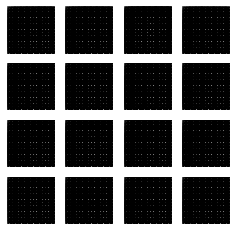

96 ... 
Total Loss : 74.9975357055664
Loss Critic : 96.02887725830078
Loss Generator : 171.0264129638672
97 ... 
Total Loss : 74.1680908203125
Loss Critic : 95.12091064453125
Loss Generator : 169.28900146484375
98 ... 
Total Loss : 76.74221801757812
Loss Critic : 94.1929931640625
Loss Generator : 170.93521118164062
99 ... 
Total Loss : 75.73701477050781
Loss Critic : 95.85734558105469
Loss Generator : 171.5943603515625
100 ... 
Total Loss : 74.78346252441406
Loss Critic : 96.04072570800781
Loss Generator : 170.82418823242188


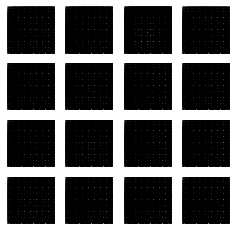

101 ... 
Total Loss : 75.92537689208984
Loss Critic : 95.58586883544922
Loss Generator : 171.51124572753906
102 ... 
Total Loss : 77.77427673339844
Loss Critic : 94.64852905273438
Loss Generator : 172.4228057861328
103 ... 
Total Loss : 73.81112670898438
Loss Critic : 96.12361145019531
Loss Generator : 169.9347381591797
104 ... 
Total Loss : 75.13633728027344
Loss Critic : 95.44638061523438
Loss Generator : 170.5827178955078
105 ... 
Total Loss : 75.82506561279297
Loss Critic : 95.71654510498047
Loss Generator : 171.54161071777344


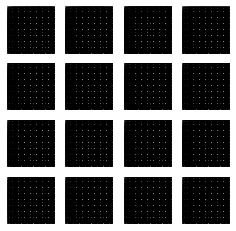

106 ... 
Total Loss : 77.19061279296875
Loss Critic : 96.19784545898438
Loss Generator : 173.38845825195312
107 ... 
Total Loss : 75.5405502319336
Loss Critic : 95.4598159790039
Loss Generator : 171.0003662109375
108 ... 
Total Loss : 74.98658752441406
Loss Critic : 94.84242248535156
Loss Generator : 169.82901000976562
109 ... 
Total Loss : 75.89885711669922
Loss Critic : 96.42916107177734
Loss Generator : 172.32801818847656
110 ... 
Total Loss : 74.93453979492188
Loss Critic : 96.2708740234375
Loss Generator : 171.20541381835938


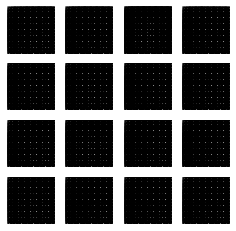

111 ... 
Total Loss : 73.73058319091797
Loss Critic : 96.5381088256836
Loss Generator : 170.26869201660156
112 ... 
Total Loss : 75.84422302246094
Loss Critic : 96.08583068847656
Loss Generator : 171.9300537109375
113 ... 
Total Loss : 73.8012924194336
Loss Critic : 94.81439971923828
Loss Generator : 168.61569213867188
114 ... 
Total Loss : 74.88119506835938
Loss Critic : 96.29086303710938
Loss Generator : 171.17205810546875
115 ... 
Total Loss : 75.63230895996094
Loss Critic : 95.87619018554688
Loss Generator : 171.5084991455078


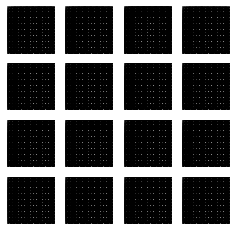

116 ... 
Total Loss : 74.41541290283203
Loss Critic : 96.19440460205078
Loss Generator : 170.6098175048828
117 ... 
Total Loss : 73.2913818359375
Loss Critic : 96.42947387695312
Loss Generator : 169.72085571289062
118 ... 
Total Loss : 77.60821533203125
Loss Critic : 97.3255615234375
Loss Generator : 174.93377685546875
119 ... 
Total Loss : 74.34797668457031
Loss Critic : 95.92054748535156
Loss Generator : 170.26852416992188
120 ... 
Total Loss : 75.78033447265625
Loss Critic : 95.86065673828125
Loss Generator : 171.6409912109375


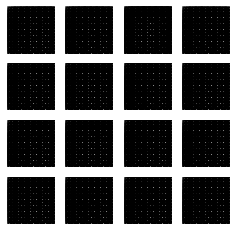

121 ... 
Total Loss : 73.3912353515625
Loss Critic : 95.43191528320312
Loss Generator : 168.82315063476562
122 ... 
Total Loss : 73.14785766601562
Loss Critic : 97.11125183105469
Loss Generator : 170.2591094970703
123 ... 
Total Loss : 72.87196350097656
Loss Critic : 94.96443176269531
Loss Generator : 167.83639526367188
124 ... 
Total Loss : 75.30579376220703
Loss Critic : 96.52484893798828
Loss Generator : 171.8306427001953
125 ... 
Total Loss : 74.76554870605469
Loss Critic : 93.92417907714844
Loss Generator : 168.68972778320312


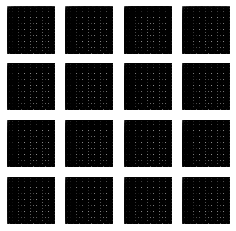

126 ... 
Total Loss : 77.87449645996094
Loss Critic : 96.0947265625
Loss Generator : 173.96922302246094
127 ... 
Total Loss : 72.2532958984375
Loss Critic : 96.93714904785156
Loss Generator : 169.19044494628906
128 ... 
Total Loss : 72.3116455078125
Loss Critic : 94.95864868164062
Loss Generator : 167.27029418945312
129 ... 
Total Loss : 76.7176742553711
Loss Critic : 96.31324005126953
Loss Generator : 173.03091430664062
130 ... 
Total Loss : 77.11954498291016
Loss Critic : 96.80660247802734
Loss Generator : 173.9261474609375


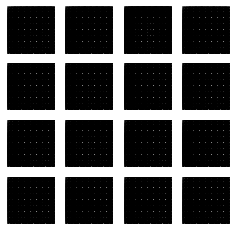

131 ... 
Total Loss : 77.43922424316406
Loss Critic : 95.52984619140625
Loss Generator : 172.9690704345703
132 ... 
Total Loss : 75.23726654052734
Loss Critic : 96.70890045166016
Loss Generator : 171.9461669921875
133 ... 
Total Loss : 74.32360076904297
Loss Critic : 95.1833267211914
Loss Generator : 169.50692749023438
134 ... 
Total Loss : 75.4429702758789
Loss Critic : 95.56969451904297
Loss Generator : 171.01266479492188
135 ... 
Total Loss : 75.45389556884766
Loss Critic : 96.81000518798828
Loss Generator : 172.26390075683594


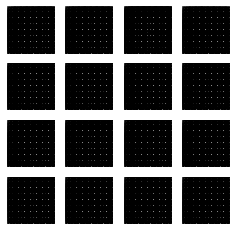

136 ... 
Total Loss : 76.50985717773438
Loss Critic : 93.65081787109375
Loss Generator : 170.16067504882812
137 ... 
Total Loss : 77.32841491699219
Loss Critic : 96.14311218261719
Loss Generator : 173.47152709960938
138 ... 
Total Loss : 73.60340881347656
Loss Critic : 95.40202331542969
Loss Generator : 169.00543212890625
139 ... 
Total Loss : 76.16728973388672
Loss Critic : 96.23223114013672
Loss Generator : 172.39952087402344
140 ... 
Total Loss : 71.47481536865234
Loss Critic : 94.3375015258789
Loss Generator : 165.81231689453125


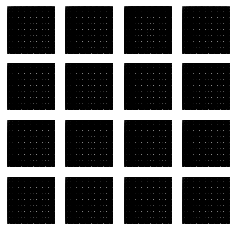

141 ... 
Total Loss : 71.45490264892578
Loss Critic : 94.44440460205078
Loss Generator : 165.89930725097656
142 ... 
Total Loss : 72.69013214111328
Loss Critic : 93.52291107177734
Loss Generator : 166.21304321289062
143 ... 
Total Loss : 75.76392364501953
Loss Critic : 96.14347076416016
Loss Generator : 171.9073944091797
144 ... 
Total Loss : 74.58064270019531
Loss Critic : 95.06221008300781
Loss Generator : 169.64285278320312
145 ... 
Total Loss : 74.632080078125
Loss Critic : 96.86418151855469
Loss Generator : 171.4962615966797


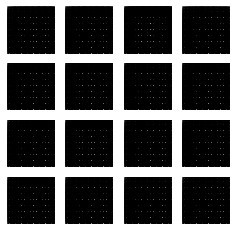

146 ... 
Total Loss : 75.83586883544922
Loss Critic : 96.76241302490234
Loss Generator : 172.59828186035156
147 ... 
Total Loss : 75.18791198730469
Loss Critic : 95.27497863769531
Loss Generator : 170.462890625
148 ... 
Total Loss : 72.78765869140625
Loss Critic : 96.12040710449219
Loss Generator : 168.90806579589844
149 ... 
Total Loss : 72.20478057861328
Loss Critic : 94.60868072509766
Loss Generator : 166.81346130371094
====== Epoch  1 ======
0 ... 
Total Loss : 73.20928955078125
Loss Critic : 95.58184814453125
Loss Generator : 168.7911376953125
1 ... 
Total Loss : 75.78115844726562
Loss Critic : 96.94599914550781
Loss Generator : 172.72715759277344
2 ... 
Total Loss : 75.21453857421875
Loss Critic : 95.97824096679688
Loss Generator : 171.19277954101562
3 ... 
Total Loss : 73.3912353515625
Loss Critic : 94.72764587402344
Loss Generator : 168.11888122558594
4 ... 
Total Loss : 73.8289794921875
Loss Critic : 96.55131530761719
Loss Generator : 170.3802947998047
5 ... 
Total Loss : 74.3

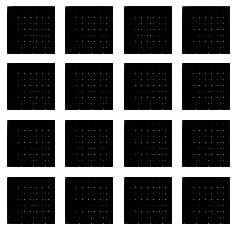

6 ... 
Total Loss : 72.3863525390625
Loss Critic : 94.87162780761719
Loss Generator : 167.2579803466797
7 ... 
Total Loss : 75.26629638671875
Loss Critic : 94.67070007324219
Loss Generator : 169.93699645996094
8 ... 
Total Loss : 71.40656280517578
Loss Critic : 94.6142349243164
Loss Generator : 166.0207977294922
9 ... 
Total Loss : 75.12295532226562
Loss Critic : 97.01766967773438
Loss Generator : 172.140625
10 ... 
Total Loss : 74.49596405029297
Loss Critic : 94.24878692626953
Loss Generator : 168.7447509765625


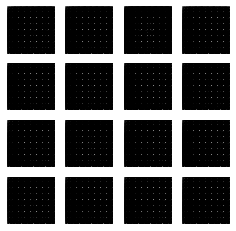

11 ... 
Total Loss : 74.28236389160156
Loss Critic : 95.26176452636719
Loss Generator : 169.54412841796875
12 ... 
Total Loss : 74.91389465332031
Loss Critic : 96.38925170898438
Loss Generator : 171.3031463623047
13 ... 
Total Loss : 73.48413848876953
Loss Critic : 95.92406463623047
Loss Generator : 169.408203125
14 ... 
Total Loss : 73.94127655029297
Loss Critic : 94.68668365478516
Loss Generator : 168.62796020507812
15 ... 
Total Loss : 73.13536834716797
Loss Critic : 94.3560562133789
Loss Generator : 167.49142456054688


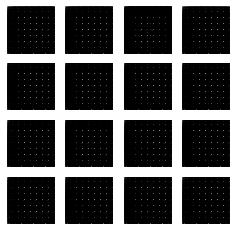

16 ... 
Total Loss : 73.24286651611328
Loss Critic : 95.2490463256836
Loss Generator : 168.49191284179688
17 ... 
Total Loss : 72.6495132446289
Loss Critic : 95.57076263427734
Loss Generator : 168.22027587890625
18 ... 
Total Loss : 71.16754150390625
Loss Critic : 96.77212524414062
Loss Generator : 167.93966674804688
19 ... 
Total Loss : 73.0583267211914
Loss Critic : 96.8904037475586
Loss Generator : 169.94873046875
20 ... 
Total Loss : 73.99071502685547
Loss Critic : 95.0356674194336
Loss Generator : 169.02638244628906


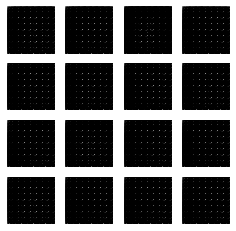

21 ... 
Total Loss : 72.64260864257812
Loss Critic : 95.8634033203125
Loss Generator : 168.50601196289062
22 ... 
Total Loss : 72.28144073486328
Loss Critic : 96.44686126708984
Loss Generator : 168.72830200195312
23 ... 
Total Loss : 71.26683807373047
Loss Critic : 95.76282501220703
Loss Generator : 167.0296630859375
24 ... 
Total Loss : 73.85493469238281
Loss Critic : 96.71412658691406
Loss Generator : 170.56906127929688
25 ... 
Total Loss : 71.665283203125
Loss Critic : 94.51092529296875
Loss Generator : 166.17620849609375


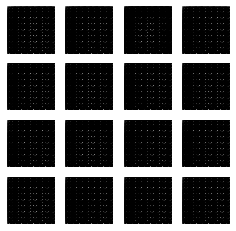

26 ... 
Total Loss : 74.33979797363281
Loss Critic : 94.76219177246094
Loss Generator : 169.10198974609375
27 ... 
Total Loss : 72.73383331298828
Loss Critic : 95.73700714111328
Loss Generator : 168.47084045410156
28 ... 
Total Loss : 73.86238098144531
Loss Critic : 94.52456665039062
Loss Generator : 168.38694763183594
29 ... 
Total Loss : 74.1510238647461
Loss Critic : 95.38776397705078
Loss Generator : 169.53878784179688
30 ... 
Total Loss : 72.75787353515625
Loss Critic : 95.95034790039062
Loss Generator : 168.70822143554688


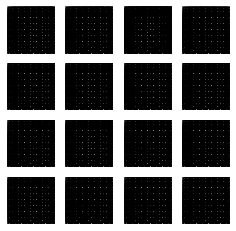

31 ... 
Total Loss : 71.31974792480469
Loss Critic : 95.77763366699219
Loss Generator : 167.09738159179688
32 ... 
Total Loss : 72.5183334350586
Loss Critic : 96.78527069091797
Loss Generator : 169.30360412597656
33 ... 
Total Loss : 72.94770812988281
Loss Critic : 96.20457458496094
Loss Generator : 169.15228271484375
34 ... 
Total Loss : 73.84455108642578
Loss Critic : 95.87683868408203
Loss Generator : 169.7213897705078
35 ... 
Total Loss : 74.2337875366211
Loss Critic : 97.31803131103516
Loss Generator : 171.55181884765625


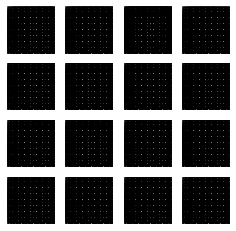

36 ... 
Total Loss : 74.25514221191406
Loss Critic : 96.46961975097656
Loss Generator : 170.72476196289062
37 ... 
Total Loss : 74.25068664550781
Loss Critic : 95.25450134277344
Loss Generator : 169.50518798828125
38 ... 
Total Loss : 72.94833374023438
Loss Critic : 96.30557250976562
Loss Generator : 169.25390625
39 ... 
Total Loss : 72.02574920654297
Loss Critic : 95.4570541381836
Loss Generator : 167.48280334472656
40 ... 
Total Loss : 71.85152435302734
Loss Critic : 95.08533477783203
Loss Generator : 166.93685913085938


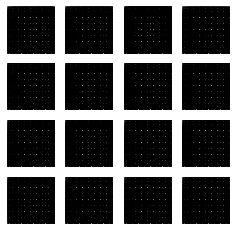

41 ... 
Total Loss : 75.59053039550781
Loss Critic : 95.52755737304688
Loss Generator : 171.1180877685547
42 ... 
Total Loss : 70.05802917480469
Loss Critic : 95.62478637695312
Loss Generator : 165.6828155517578
43 ... 
Total Loss : 71.89070892333984
Loss Critic : 96.20084381103516
Loss Generator : 168.091552734375
44 ... 
Total Loss : 74.419189453125
Loss Critic : 97.29164123535156
Loss Generator : 171.71083068847656
45 ... 
Total Loss : 71.40950775146484
Loss Critic : 96.43317413330078
Loss Generator : 167.84268188476562


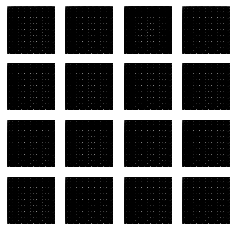

46 ... 
Total Loss : 70.39746856689453
Loss Critic : 94.4162368774414
Loss Generator : 164.81370544433594
47 ... 
Total Loss : 70.28704071044922
Loss Critic : 94.2343521118164
Loss Generator : 164.52139282226562
48 ... 
Total Loss : 71.4249038696289
Loss Critic : 95.7253189086914
Loss Generator : 167.1502227783203
49 ... 
Total Loss : 70.1450424194336
Loss Critic : 93.53804779052734
Loss Generator : 163.68309020996094
50 ... 
Total Loss : 69.82137298583984
Loss Critic : 95.03487396240234
Loss Generator : 164.8562469482422


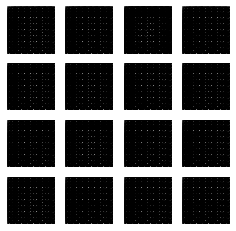

51 ... 
Total Loss : 72.21910858154297
Loss Critic : 96.39545440673828
Loss Generator : 168.61456298828125
52 ... 
Total Loss : 70.03138732910156
Loss Critic : 96.50419616699219
Loss Generator : 166.53558349609375
53 ... 
Total Loss : 71.58248138427734
Loss Critic : 95.82486724853516
Loss Generator : 167.4073486328125
54 ... 
Total Loss : 71.3446044921875
Loss Critic : 97.0699462890625
Loss Generator : 168.41455078125
55 ... 
Total Loss : 73.37691497802734
Loss Critic : 96.49152374267578
Loss Generator : 169.86843872070312


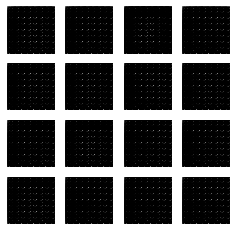

56 ... 
Total Loss : 73.4350357055664
Loss Critic : 96.64305877685547
Loss Generator : 170.07809448242188
57 ... 
Total Loss : 73.83283233642578
Loss Critic : 95.79314422607422
Loss Generator : 169.6259765625
58 ... 
Total Loss : 73.01484680175781
Loss Critic : 97.22958374023438
Loss Generator : 170.2444305419922
59 ... 
Total Loss : 72.57673645019531
Loss Critic : 96.024658203125
Loss Generator : 168.6013946533203
60 ... 
Total Loss : 72.31830596923828
Loss Critic : 94.87940216064453
Loss Generator : 167.1977081298828


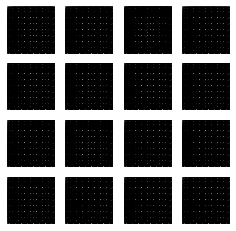

61 ... 
Total Loss : 71.94229888916016
Loss Critic : 95.32540130615234
Loss Generator : 167.2677001953125
62 ... 
Total Loss : 70.03531646728516
Loss Critic : 95.56624603271484
Loss Generator : 165.6015625
63 ... 
Total Loss : 69.92498016357422
Loss Critic : 95.61502838134766
Loss Generator : 165.54000854492188
64 ... 
Total Loss : 72.2057876586914
Loss Critic : 95.65459442138672
Loss Generator : 167.86038208007812
65 ... 
Total Loss : 70.86459350585938
Loss Critic : 93.16307067871094
Loss Generator : 164.0276641845703


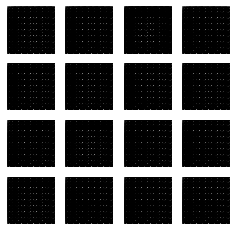

66 ... 
Total Loss : 73.04519653320312
Loss Critic : 96.31423950195312
Loss Generator : 169.35943603515625
67 ... 
Total Loss : 72.29647064208984
Loss Critic : 96.25873565673828
Loss Generator : 168.55520629882812
68 ... 
Total Loss : 73.87430572509766
Loss Critic : 96.98181915283203
Loss Generator : 170.8561248779297
69 ... 
Total Loss : 73.50557708740234
Loss Critic : 97.80158233642578
Loss Generator : 171.30715942382812
70 ... 
Total Loss : 72.5333251953125
Loss Critic : 97.08377075195312
Loss Generator : 169.61709594726562


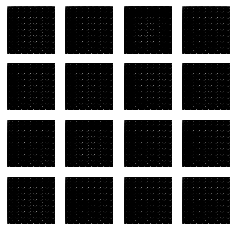

71 ... 
Total Loss : 74.08621215820312
Loss Critic : 96.45637512207031
Loss Generator : 170.54258728027344
72 ... 
Total Loss : 71.06527709960938
Loss Critic : 95.52510070800781
Loss Generator : 166.5903778076172
73 ... 
Total Loss : 71.84124755859375
Loss Critic : 96.53395080566406
Loss Generator : 168.3751983642578
74 ... 
Total Loss : 74.12529754638672
Loss Critic : 97.28069305419922
Loss Generator : 171.40599060058594
75 ... 
Total Loss : 72.12269592285156
Loss Critic : 95.95829772949219
Loss Generator : 168.08099365234375


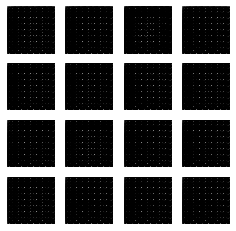

76 ... 
Total Loss : 74.87606048583984
Loss Critic : 96.96495819091797
Loss Generator : 171.8410186767578
77 ... 
Total Loss : 70.63660430908203
Loss Critic : 96.62090301513672
Loss Generator : 167.25750732421875
78 ... 
Total Loss : 70.98589324951172
Loss Critic : 96.69644927978516
Loss Generator : 167.68234252929688
79 ... 
Total Loss : 67.96922302246094
Loss Critic : 93.66145324707031
Loss Generator : 161.63067626953125
80 ... 
Total Loss : 71.20716857910156
Loss Critic : 97.37777709960938
Loss Generator : 168.58494567871094


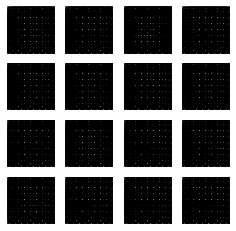

81 ... 
Total Loss : 75.10811614990234
Loss Critic : 97.48445892333984
Loss Generator : 172.5925750732422
82 ... 
Total Loss : 70.51042175292969
Loss Critic : 95.770263671875
Loss Generator : 166.2806854248047
83 ... 
Total Loss : 72.3176040649414
Loss Critic : 97.42740631103516
Loss Generator : 169.74501037597656
84 ... 
Total Loss : 71.94155883789062
Loss Critic : 97.07669067382812
Loss Generator : 169.01824951171875
85 ... 
Total Loss : 69.9170913696289
Loss Critic : 96.56189727783203
Loss Generator : 166.47898864746094


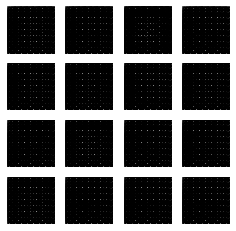

86 ... 
Total Loss : 68.91870880126953
Loss Critic : 98.37291717529297
Loss Generator : 167.2916259765625
87 ... 
Total Loss : 70.82434844970703
Loss Critic : 96.42719268798828
Loss Generator : 167.2515411376953
88 ... 
Total Loss : 69.88726806640625
Loss Critic : 96.65219116210938
Loss Generator : 166.53945922851562
89 ... 
Total Loss : 71.46109008789062
Loss Critic : 95.60012817382812
Loss Generator : 167.06121826171875
90 ... 
Total Loss : 71.11137390136719
Loss Critic : 95.51043701171875
Loss Generator : 166.62181091308594


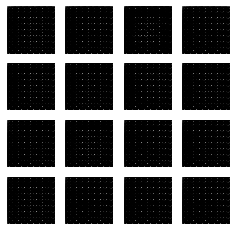

91 ... 
Total Loss : 68.25824737548828
Loss Critic : 97.48026275634766
Loss Generator : 165.73851013183594
92 ... 
Total Loss : 69.7537612915039
Loss Critic : 95.60637664794922
Loss Generator : 165.36013793945312
93 ... 
Total Loss : 69.42446899414062
Loss Critic : 95.66644287109375
Loss Generator : 165.09091186523438
94 ... 
Total Loss : 69.13300323486328
Loss Critic : 95.38054656982422
Loss Generator : 164.5135498046875
95 ... 
Total Loss : 70.4843978881836
Loss Critic : 96.48404693603516
Loss Generator : 166.96844482421875


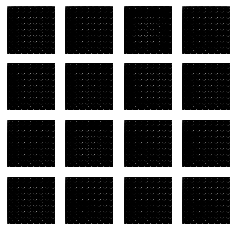

96 ... 
Total Loss : 70.87071228027344
Loss Critic : 96.40481567382812
Loss Generator : 167.27552795410156
97 ... 
Total Loss : 67.85856628417969
Loss Critic : 96.66606140136719
Loss Generator : 164.52462768554688
98 ... 
Total Loss : 72.00332641601562
Loss Critic : 96.57656860351562
Loss Generator : 168.57989501953125
99 ... 
Total Loss : 71.52845001220703
Loss Critic : 96.59622955322266
Loss Generator : 168.1246795654297
100 ... 
Total Loss : 70.88919067382812
Loss Critic : 96.79898071289062
Loss Generator : 167.68817138671875


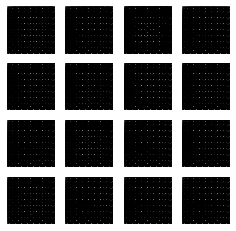

101 ... 
Total Loss : 68.52444458007812
Loss Critic : 96.78378295898438
Loss Generator : 165.3082275390625
102 ... 
Total Loss : 69.90936279296875
Loss Critic : 99.56898498535156
Loss Generator : 169.4783477783203
103 ... 
Total Loss : 70.49134063720703
Loss Critic : 96.8592300415039
Loss Generator : 167.35057067871094
104 ... 
Total Loss : 70.66802978515625
Loss Critic : 98.14703369140625
Loss Generator : 168.8150634765625
105 ... 
Total Loss : 68.78892517089844
Loss Critic : 97.80545043945312
Loss Generator : 166.59437561035156


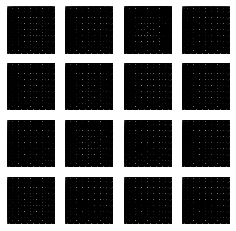

106 ... 
Total Loss : 70.52165985107422
Loss Critic : 97.7740249633789
Loss Generator : 168.29568481445312
107 ... 
Total Loss : 72.1377944946289
Loss Critic : 95.3045425415039
Loss Generator : 167.4423370361328
108 ... 
Total Loss : 72.27066802978516
Loss Critic : 94.92693328857422
Loss Generator : 167.19760131835938
109 ... 
Total Loss : 71.64726257324219
Loss Critic : 97.30511474609375
Loss Generator : 168.95237731933594
110 ... 
Total Loss : 69.90161895751953
Loss Critic : 97.19847869873047
Loss Generator : 167.10009765625


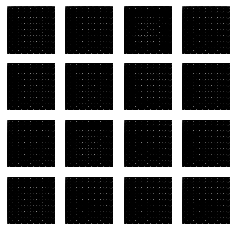

111 ... 
Total Loss : 71.39230346679688
Loss Critic : 97.06814575195312
Loss Generator : 168.46044921875
112 ... 
Total Loss : 71.33179473876953
Loss Critic : 97.29442596435547
Loss Generator : 168.626220703125
113 ... 
Total Loss : 70.99748992919922
Loss Critic : 97.4046401977539
Loss Generator : 168.40213012695312
114 ... 
Total Loss : 71.63475799560547
Loss Critic : 96.66240692138672
Loss Generator : 168.2971649169922
115 ... 
Total Loss : 68.42737579345703
Loss Critic : 98.44092559814453
Loss Generator : 166.86830139160156


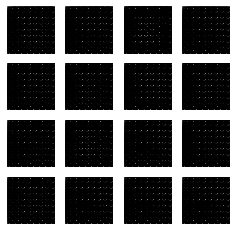

116 ... 
Total Loss : 67.61558532714844
Loss Critic : 95.25794982910156
Loss Generator : 162.87353515625
117 ... 
Total Loss : 68.86659240722656
Loss Critic : 97.58091735839844
Loss Generator : 166.447509765625
118 ... 
Total Loss : 70.08495330810547
Loss Critic : 97.64612579345703
Loss Generator : 167.7310791015625
119 ... 
Total Loss : 69.54622650146484
Loss Critic : 97.49048614501953
Loss Generator : 167.03671264648438
120 ... 
Total Loss : 69.37239074707031
Loss Critic : 96.60313415527344
Loss Generator : 165.97552490234375


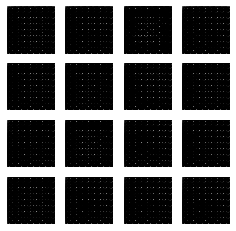

121 ... 
Total Loss : 70.32093811035156
Loss Critic : 100.02496337890625
Loss Generator : 170.3459014892578
122 ... 
Total Loss : 71.00584411621094
Loss Critic : 97.96041870117188
Loss Generator : 168.9662628173828
123 ... 
Total Loss : 70.78253936767578
Loss Critic : 96.8012466430664
Loss Generator : 167.5837860107422
124 ... 
Total Loss : 72.72573852539062
Loss Critic : 97.884765625
Loss Generator : 170.61050415039062
125 ... 
Total Loss : 69.90037536621094
Loss Critic : 96.75849914550781
Loss Generator : 166.65887451171875


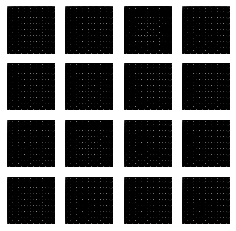

126 ... 
Total Loss : 70.67473602294922
Loss Critic : 96.4568862915039
Loss Generator : 167.13162231445312
127 ... 
Total Loss : 69.46980285644531
Loss Critic : 97.67770385742188
Loss Generator : 167.1475067138672
128 ... 
Total Loss : 70.40399932861328
Loss Critic : 97.8691635131836
Loss Generator : 168.27316284179688
129 ... 
Total Loss : 72.76095581054688
Loss Critic : 98.98074340820312
Loss Generator : 171.74169921875
130 ... 
Total Loss : 69.5987548828125
Loss Critic : 97.7742919921875
Loss Generator : 167.373046875


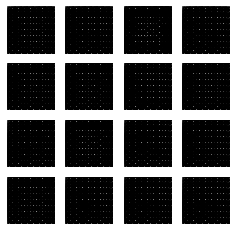

131 ... 
Total Loss : 71.25474548339844
Loss Critic : 97.69822692871094
Loss Generator : 168.95297241210938
132 ... 
Total Loss : 70.66119384765625
Loss Critic : 100.10009765625
Loss Generator : 170.76129150390625
133 ... 
Total Loss : 68.50173950195312
Loss Critic : 98.14938354492188
Loss Generator : 166.651123046875
134 ... 
Total Loss : 70.04429626464844
Loss Critic : 96.6859130859375
Loss Generator : 166.73020935058594
135 ... 
Total Loss : 69.3872299194336
Loss Critic : 97.27880096435547
Loss Generator : 166.66603088378906


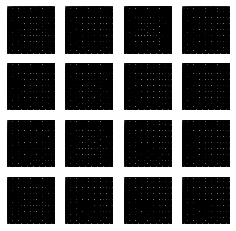

136 ... 
Total Loss : 69.95291137695312
Loss Critic : 97.12492370605469
Loss Generator : 167.0778350830078
137 ... 
Total Loss : 70.10150909423828
Loss Critic : 96.13603973388672
Loss Generator : 166.237548828125
138 ... 
Total Loss : 74.28340911865234
Loss Critic : 98.3178482055664
Loss Generator : 172.60125732421875
139 ... 
Total Loss : 70.61399841308594
Loss Critic : 98.67697143554688
Loss Generator : 169.2909698486328
140 ... 
Total Loss : 71.71776580810547
Loss Critic : 98.09117889404297
Loss Generator : 169.80894470214844


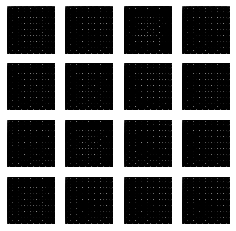

141 ... 
Total Loss : 68.81085968017578
Loss Critic : 97.85877227783203
Loss Generator : 166.6696319580078
142 ... 
Total Loss : 72.10833740234375
Loss Critic : 98.05052185058594
Loss Generator : 170.1588592529297
143 ... 
Total Loss : 70.97332763671875
Loss Critic : 97.66500854492188
Loss Generator : 168.63833618164062
144 ... 
Total Loss : 69.14811706542969
Loss Critic : 98.16786193847656
Loss Generator : 167.31597900390625
145 ... 
Total Loss : 71.17398834228516
Loss Critic : 98.88765716552734
Loss Generator : 170.0616455078125


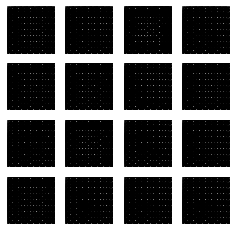

146 ... 
Total Loss : 70.0407485961914
Loss Critic : 98.20279693603516
Loss Generator : 168.24354553222656
147 ... 
Total Loss : 70.05218505859375
Loss Critic : 97.48434448242188
Loss Generator : 167.53652954101562
148 ... 
Total Loss : 66.11011505126953
Loss Critic : 97.02376556396484
Loss Generator : 163.13388061523438
149 ... 
Total Loss : 70.75574493408203
Loss Critic : 99.13069915771484
Loss Generator : 169.88644409179688
====== Epoch  2 ======
0 ... 
Total Loss : 69.21263885498047
Loss Critic : 96.87064361572266
Loss Generator : 166.08328247070312
1 ... 
Total Loss : 69.4769058227539
Loss Critic : 97.44034576416016
Loss Generator : 166.91725158691406
2 ... 
Total Loss : 71.94723510742188
Loss Critic : 99.21755981445312
Loss Generator : 171.164794921875
3 ... 
Total Loss : 68.65583038330078
Loss Critic : 99.10186004638672
Loss Generator : 167.7576904296875
4 ... 
Total Loss : 69.14148712158203
Loss Critic : 99.9828872680664
Loss Generator : 169.12437438964844
5 ... 
Total Loss : 6

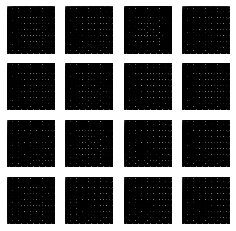

6 ... 
Total Loss : 70.81587219238281
Loss Critic : 98.80934143066406
Loss Generator : 169.62521362304688
7 ... 
Total Loss : 70.17962646484375
Loss Critic : 96.21063232421875
Loss Generator : 166.3902587890625
8 ... 
Total Loss : 72.06425476074219
Loss Critic : 99.95359802246094
Loss Generator : 172.01785278320312
9 ... 
Total Loss : 71.42256164550781
Loss Critic : 100.24574279785156
Loss Generator : 171.66830444335938
10 ... 
Total Loss : 66.75362396240234
Loss Critic : 98.70291900634766
Loss Generator : 165.45654296875


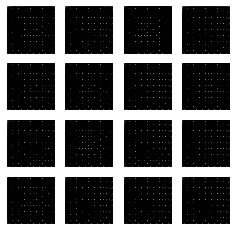

11 ... 
Total Loss : 69.25304412841797
Loss Critic : 97.9717025756836
Loss Generator : 167.22474670410156
12 ... 
Total Loss : 67.20294952392578
Loss Critic : 98.91365814208984
Loss Generator : 166.11660766601562
13 ... 
Total Loss : 68.88632202148438
Loss Critic : 99.92036437988281
Loss Generator : 168.8066864013672
14 ... 
Total Loss : 69.04682922363281
Loss Critic : 99.51252746582031
Loss Generator : 168.55935668945312
15 ... 
Total Loss : 68.13599395751953
Loss Critic : 99.24498748779297
Loss Generator : 167.3809814453125


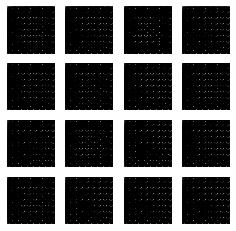

16 ... 
Total Loss : 68.79966735839844
Loss Critic : 100.43777465820312
Loss Generator : 169.23744201660156
17 ... 
Total Loss : 67.81595611572266
Loss Critic : 100.08704376220703
Loss Generator : 167.9029998779297
18 ... 
Total Loss : 70.0239028930664
Loss Critic : 99.1648178100586
Loss Generator : 169.188720703125
19 ... 
Total Loss : 70.40959930419922
Loss Critic : 99.58301544189453
Loss Generator : 169.99261474609375
20 ... 
Total Loss : 69.08466339111328
Loss Critic : 99.65154266357422
Loss Generator : 168.7362060546875


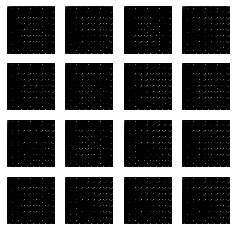

21 ... 
Total Loss : 67.2020263671875
Loss Critic : 101.32492065429688
Loss Generator : 168.52694702148438
22 ... 
Total Loss : 66.75386047363281
Loss Critic : 99.34242248535156
Loss Generator : 166.09628295898438
23 ... 
Total Loss : 66.01628112792969
Loss Critic : 99.06846618652344
Loss Generator : 165.08474731445312
24 ... 
Total Loss : 68.40605163574219
Loss Critic : 101.16926574707031
Loss Generator : 169.5753173828125
25 ... 
Total Loss : 65.8191146850586
Loss Critic : 100.50408172607422
Loss Generator : 166.3231964111328


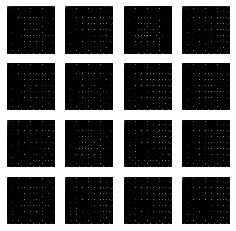

26 ... 
Total Loss : 68.78568267822266
Loss Critic : 101.59615325927734
Loss Generator : 170.3818359375
27 ... 
Total Loss : 66.96989440917969
Loss Critic : 98.87892150878906
Loss Generator : 165.84881591796875
28 ... 
Total Loss : 69.26264953613281
Loss Critic : 101.78797912597656
Loss Generator : 171.05062866210938
29 ... 
Total Loss : 67.60629272460938
Loss Critic : 100.86198425292969
Loss Generator : 168.46827697753906
30 ... 
Total Loss : 67.36463928222656
Loss Critic : 99.49446105957031
Loss Generator : 166.85910034179688


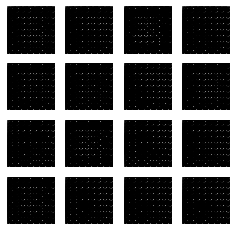

31 ... 
Total Loss : 69.56950378417969
Loss Critic : 99.479248046875
Loss Generator : 169.0487518310547
32 ... 
Total Loss : 69.20173645019531
Loss Critic : 101.19528198242188
Loss Generator : 170.3970184326172
33 ... 
Total Loss : 70.7716293334961
Loss Critic : 101.4378890991211
Loss Generator : 172.2095184326172
34 ... 
Total Loss : 67.1529769897461
Loss Critic : 100.62833404541016
Loss Generator : 167.78131103515625
35 ... 
Total Loss : 67.90386962890625
Loss Critic : 101.00762939453125
Loss Generator : 168.9114990234375


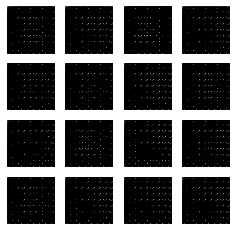

36 ... 
Total Loss : 67.39617919921875
Loss Critic : 102.22482299804688
Loss Generator : 169.62100219726562
37 ... 
Total Loss : 67.51480865478516
Loss Critic : 100.66069793701172
Loss Generator : 168.17550659179688
38 ... 
Total Loss : 69.1344985961914
Loss Critic : 100.7156753540039
Loss Generator : 169.8501739501953
39 ... 
Total Loss : 67.39045715332031
Loss Critic : 100.53666687011719
Loss Generator : 167.9271240234375
40 ... 
Total Loss : 69.55984497070312
Loss Critic : 101.43406677246094
Loss Generator : 170.99391174316406


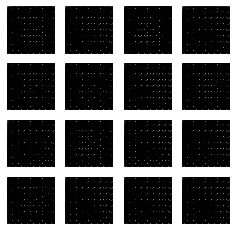

41 ... 
Total Loss : 65.41082000732422
Loss Critic : 100.3298568725586
Loss Generator : 165.7406768798828
42 ... 
Total Loss : 68.96783447265625
Loss Critic : 100.33866882324219
Loss Generator : 169.30650329589844
43 ... 
Total Loss : 67.65612030029297
Loss Critic : 101.5877456665039
Loss Generator : 169.24386596679688
44 ... 
Total Loss : 63.726829528808594
Loss Critic : 100.32341766357422
Loss Generator : 164.0502471923828
45 ... 
Total Loss : 66.59601593017578
Loss Critic : 101.2122573852539
Loss Generator : 167.8082733154297


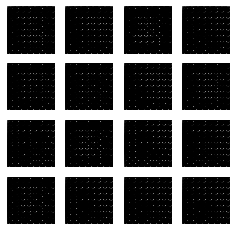

46 ... 
Total Loss : 67.13827514648438
Loss Critic : 100.32992553710938
Loss Generator : 167.46820068359375
47 ... 
Total Loss : 71.09730529785156
Loss Critic : 101.26176452636719
Loss Generator : 172.35906982421875
48 ... 
Total Loss : 69.0331802368164
Loss Critic : 99.16922760009766
Loss Generator : 168.20240783691406
49 ... 
Total Loss : 67.618896484375
Loss Critic : 99.80374145507812
Loss Generator : 167.42263793945312
50 ... 
Total Loss : 68.78387451171875
Loss Critic : 100.99885559082031
Loss Generator : 169.78273010253906


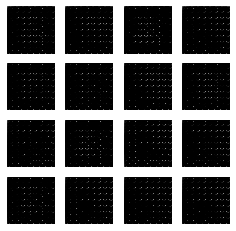

51 ... 
Total Loss : 68.20846557617188
Loss Critic : 101.51817321777344
Loss Generator : 169.7266387939453
52 ... 
Total Loss : 68.3343734741211
Loss Critic : 100.78360748291016
Loss Generator : 169.11798095703125
53 ... 
Total Loss : 65.38968658447266
Loss Critic : 99.5456314086914
Loss Generator : 164.93531799316406
54 ... 
Total Loss : 68.87057495117188
Loss Critic : 101.82762145996094
Loss Generator : 170.6981964111328
55 ... 
Total Loss : 65.77169036865234
Loss Critic : 101.1498794555664
Loss Generator : 166.92156982421875


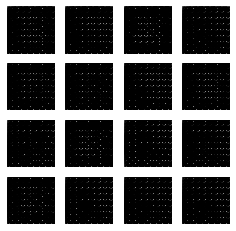

56 ... 
Total Loss : 70.23686218261719
Loss Critic : 102.29315185546875
Loss Generator : 172.53001403808594
57 ... 
Total Loss : 65.49529266357422
Loss Critic : 100.8102035522461
Loss Generator : 166.3054962158203
58 ... 
Total Loss : 68.85902404785156
Loss Critic : 101.95762634277344
Loss Generator : 170.816650390625
59 ... 
Total Loss : 68.70872497558594
Loss Critic : 103.3681640625
Loss Generator : 172.07688903808594
60 ... 
Total Loss : 68.66648864746094
Loss Critic : 102.63386535644531
Loss Generator : 171.30035400390625


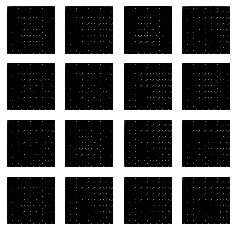

61 ... 
Total Loss : 68.79751586914062
Loss Critic : 101.8599853515625
Loss Generator : 170.65750122070312
62 ... 
Total Loss : 68.13223266601562
Loss Critic : 102.51264953613281
Loss Generator : 170.64488220214844
63 ... 
Total Loss : 68.21669006347656
Loss Critic : 102.81065368652344
Loss Generator : 171.02734375
64 ... 
Total Loss : 68.41926574707031
Loss Critic : 103.64912414550781
Loss Generator : 172.06838989257812
65 ... 
Total Loss : 67.19634246826172
Loss Critic : 103.32428741455078
Loss Generator : 170.5206298828125


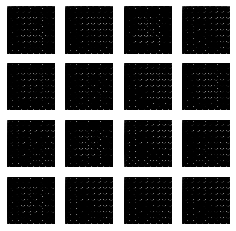

66 ... 
Total Loss : 69.1801986694336
Loss Critic : 104.1875228881836
Loss Generator : 173.3677215576172
67 ... 
Total Loss : 65.9814682006836
Loss Critic : 103.13619232177734
Loss Generator : 169.11766052246094
68 ... 
Total Loss : 70.0194091796875
Loss Critic : 103.65557861328125
Loss Generator : 173.67498779296875
69 ... 
Total Loss : 67.07034301757812
Loss Critic : 103.8018798828125
Loss Generator : 170.87222290039062
70 ... 
Total Loss : 67.06058502197266
Loss Critic : 103.68526458740234
Loss Generator : 170.745849609375


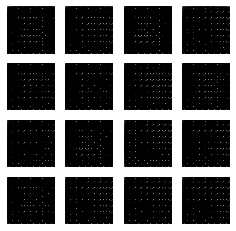

71 ... 
Total Loss : 67.3153076171875
Loss Critic : 102.34603881835938
Loss Generator : 169.66134643554688
72 ... 
Total Loss : 66.74175262451172
Loss Critic : 102.40901947021484
Loss Generator : 169.15077209472656
73 ... 
Total Loss : 67.0340805053711
Loss Critic : 103.25110626220703
Loss Generator : 170.28518676757812
74 ... 
Total Loss : 66.95832061767578
Loss Critic : 102.32622528076172
Loss Generator : 169.2845458984375
75 ... 
Total Loss : 66.95059204101562
Loss Critic : 103.32521057128906
Loss Generator : 170.2758026123047


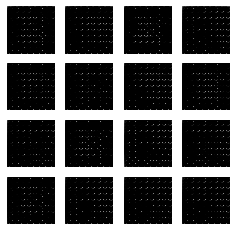

76 ... 
Total Loss : 68.05645751953125
Loss Critic : 103.481689453125
Loss Generator : 171.53814697265625
77 ... 
Total Loss : 65.84685516357422
Loss Critic : 103.30814361572266
Loss Generator : 169.15499877929688
78 ... 
Total Loss : 67.62853240966797
Loss Critic : 103.1579360961914
Loss Generator : 170.78646850585938
79 ... 
Total Loss : 65.2303466796875
Loss Critic : 102.40336608886719
Loss Generator : 167.6337127685547
80 ... 
Total Loss : 66.6375961303711
Loss Critic : 102.8877944946289
Loss Generator : 169.525390625


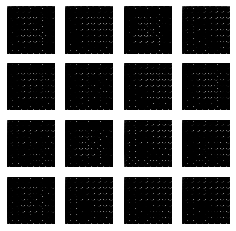

81 ... 
Total Loss : 66.47787475585938
Loss Critic : 99.58563232421875
Loss Generator : 166.06350708007812
82 ... 
Total Loss : 64.85877990722656
Loss Critic : 102.43208312988281
Loss Generator : 167.29086303710938
83 ... 
Total Loss : 68.37345123291016
Loss Critic : 105.06018829345703
Loss Generator : 173.4336395263672
84 ... 
Total Loss : 66.81908416748047
Loss Critic : 103.72232818603516
Loss Generator : 170.54141235351562
85 ... 
Total Loss : 66.65966796875
Loss Critic : 104.54855346679688
Loss Generator : 171.20822143554688


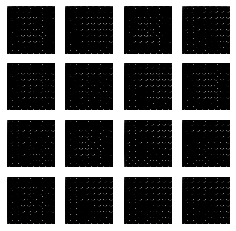

86 ... 
Total Loss : 63.783233642578125
Loss Critic : 104.45252990722656
Loss Generator : 168.2357635498047
87 ... 
Total Loss : 65.33670043945312
Loss Critic : 104.452392578125
Loss Generator : 169.78909301757812
88 ... 
Total Loss : 67.72693634033203
Loss Critic : 104.20294952392578
Loss Generator : 171.9298858642578
89 ... 
Total Loss : 65.04153442382812
Loss Critic : 103.94438171386719
Loss Generator : 168.9859161376953
90 ... 
Total Loss : 65.9883804321289
Loss Critic : 104.3598861694336
Loss Generator : 170.3482666015625


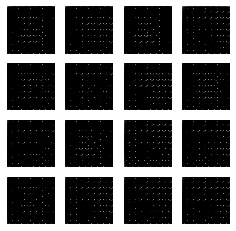

91 ... 
Total Loss : 66.48955535888672
Loss Critic : 103.9355239868164
Loss Generator : 170.42507934570312
92 ... 
Total Loss : 65.18079376220703
Loss Critic : 104.35059356689453
Loss Generator : 169.53138732910156
93 ... 
Total Loss : 66.9866714477539
Loss Critic : 105.18871307373047
Loss Generator : 172.17538452148438
94 ... 
Total Loss : 64.048095703125
Loss Critic : 103.45294189453125
Loss Generator : 167.50103759765625
95 ... 
Total Loss : 68.67701721191406
Loss Critic : 105.4454345703125
Loss Generator : 174.12245178222656


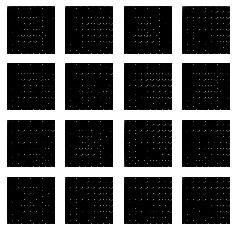

96 ... 
Total Loss : 67.39012908935547
Loss Critic : 103.9436264038086
Loss Generator : 171.33375549316406
97 ... 
Total Loss : 62.796363830566406
Loss Critic : 101.37703704833984
Loss Generator : 164.17340087890625
98 ... 
Total Loss : 64.18927001953125
Loss Critic : 103.46878051757812
Loss Generator : 167.65805053710938
99 ... 
Total Loss : 65.35108947753906
Loss Critic : 104.64103698730469
Loss Generator : 169.99212646484375
100 ... 
Total Loss : 67.66844940185547
Loss Critic : 104.92520904541016
Loss Generator : 172.59365844726562


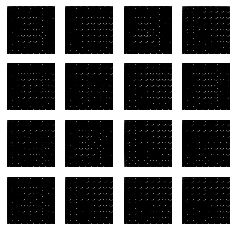

101 ... 
Total Loss : 67.18601989746094
Loss Critic : 105.42756652832031
Loss Generator : 172.61358642578125
102 ... 
Total Loss : 66.65556335449219
Loss Critic : 104.46022033691406
Loss Generator : 171.11578369140625
103 ... 
Total Loss : 65.2658462524414
Loss Critic : 104.98273468017578
Loss Generator : 170.2485809326172
104 ... 
Total Loss : 63.800689697265625
Loss Critic : 105.33535766601562
Loss Generator : 169.13604736328125
105 ... 
Total Loss : 66.81044006347656
Loss Critic : 103.32315063476562
Loss Generator : 170.1335906982422


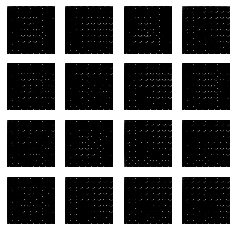

106 ... 
Total Loss : 65.30464172363281
Loss Critic : 104.37059020996094
Loss Generator : 169.67523193359375
107 ... 
Total Loss : 63.495849609375
Loss Critic : 104.59919738769531
Loss Generator : 168.0950469970703
108 ... 
Total Loss : 66.83380889892578
Loss Critic : 103.3493423461914
Loss Generator : 170.1831512451172
109 ... 
Total Loss : 63.805625915527344
Loss Critic : 104.37787628173828
Loss Generator : 168.18350219726562
110 ... 
Total Loss : 67.4061050415039
Loss Critic : 104.65860748291016
Loss Generator : 172.06471252441406


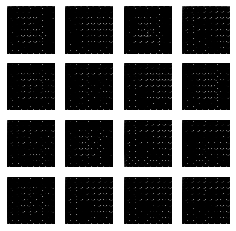

111 ... 
Total Loss : 66.42306518554688
Loss Critic : 106.92849731445312
Loss Generator : 173.3515625
112 ... 
Total Loss : 66.85556030273438
Loss Critic : 105.387451171875
Loss Generator : 172.24301147460938
113 ... 
Total Loss : 67.31344604492188
Loss Critic : 106.05793762207031
Loss Generator : 173.3713836669922
114 ... 
Total Loss : 64.9756851196289
Loss Critic : 106.8836898803711
Loss Generator : 171.859375
115 ... 
Total Loss : 65.2498779296875
Loss Critic : 104.33258056640625
Loss Generator : 169.58245849609375


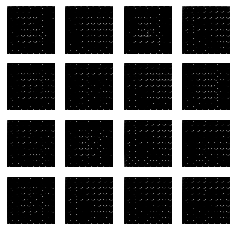

116 ... 
Total Loss : 65.2225341796875
Loss Critic : 105.65931701660156
Loss Generator : 170.88185119628906
117 ... 
Total Loss : 65.54227447509766
Loss Critic : 103.63909149169922
Loss Generator : 169.18136596679688
118 ... 
Total Loss : 65.87699890136719
Loss Critic : 104.78445434570312
Loss Generator : 170.6614532470703
119 ... 
Total Loss : 64.01155853271484
Loss Critic : 106.23253631591797
Loss Generator : 170.2440948486328
120 ... 
Total Loss : 66.38203430175781
Loss Critic : 105.219970703125
Loss Generator : 171.6020050048828


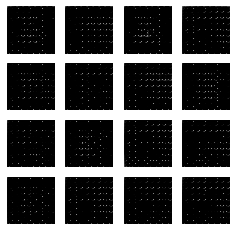

121 ... 
Total Loss : 67.55448150634766
Loss Critic : 105.70964813232422
Loss Generator : 173.26412963867188
122 ... 
Total Loss : 67.07295227050781
Loss Critic : 104.90711975097656
Loss Generator : 171.98007202148438
123 ... 
Total Loss : 63.23694610595703
Loss Critic : 105.60611724853516
Loss Generator : 168.8430633544922
124 ... 
Total Loss : 64.4715576171875
Loss Critic : 105.83041381835938
Loss Generator : 170.30197143554688
125 ... 
Total Loss : 64.38772583007812
Loss Critic : 103.65213012695312
Loss Generator : 168.03985595703125


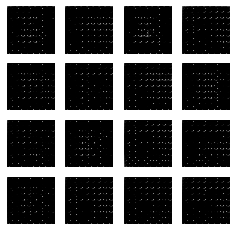

126 ... 
Total Loss : 67.01959228515625
Loss Critic : 104.80978393554688
Loss Generator : 171.82937622070312
127 ... 
Total Loss : 64.80946350097656
Loss Critic : 107.34420776367188
Loss Generator : 172.15367126464844
128 ... 
Total Loss : 66.99763488769531
Loss Critic : 107.94233703613281
Loss Generator : 174.93997192382812
129 ... 
Total Loss : 65.35005187988281
Loss Critic : 107.99351501464844
Loss Generator : 173.34356689453125
130 ... 
Total Loss : 63.31511688232422
Loss Critic : 107.87854766845703
Loss Generator : 171.19366455078125


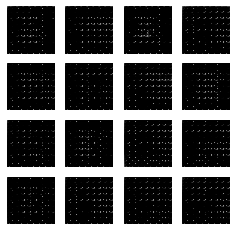

131 ... 
Total Loss : 63.92530822753906
Loss Critic : 105.88362121582031
Loss Generator : 169.80892944335938
132 ... 
Total Loss : 64.73223876953125
Loss Critic : 107.44329833984375
Loss Generator : 172.175537109375
133 ... 
Total Loss : 66.74727630615234
Loss Critic : 108.22638702392578
Loss Generator : 174.97366333007812
134 ... 
Total Loss : 68.27350616455078
Loss Critic : 108.50251007080078
Loss Generator : 176.77601623535156
135 ... 
Total Loss : 62.83056640625
Loss Critic : 107.15560913085938
Loss Generator : 169.98617553710938


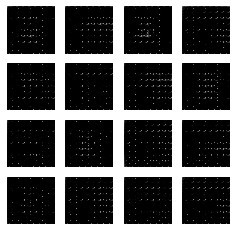

136 ... 
Total Loss : 65.01756286621094
Loss Critic : 106.57789611816406
Loss Generator : 171.595458984375
137 ... 
Total Loss : 64.83885192871094
Loss Critic : 107.18464660644531
Loss Generator : 172.02349853515625
138 ... 
Total Loss : 64.74717712402344
Loss Critic : 106.17109680175781
Loss Generator : 170.91827392578125
139 ... 
Total Loss : 62.52690887451172
Loss Critic : 107.8479995727539
Loss Generator : 170.37490844726562
140 ... 
Total Loss : 64.70603942871094
Loss Critic : 108.9017333984375
Loss Generator : 173.60777282714844


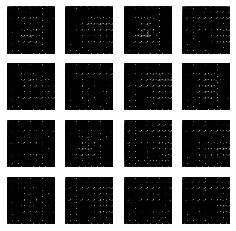

141 ... 
Total Loss : 65.58277893066406
Loss Critic : 108.60881042480469
Loss Generator : 174.19158935546875
142 ... 
Total Loss : 64.62703704833984
Loss Critic : 111.48755645751953
Loss Generator : 176.11459350585938
143 ... 
Total Loss : 64.432373046875
Loss Critic : 109.07647705078125
Loss Generator : 173.50885009765625
144 ... 
Total Loss : 63.86974334716797
Loss Critic : 112.4633560180664
Loss Generator : 176.33309936523438
145 ... 
Total Loss : 63.30327606201172
Loss Critic : 114.81403350830078
Loss Generator : 178.1173095703125


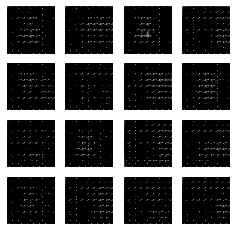

146 ... 
Total Loss : 63.83141326904297
Loss Critic : 113.0703353881836
Loss Generator : 176.90174865722656
147 ... 
Total Loss : 62.84735870361328
Loss Critic : 112.44954681396484
Loss Generator : 175.29690551757812
148 ... 
Total Loss : 64.2135009765625
Loss Critic : 115.55239868164062
Loss Generator : 179.76589965820312
149 ... 
Total Loss : 61.045440673828125
Loss Critic : 114.10215759277344
Loss Generator : 175.14759826660156
====== Epoch  3 ======
0 ... 
Total Loss : 62.26628875732422
Loss Critic : 114.7626724243164
Loss Generator : 177.02896118164062
1 ... 
Total Loss : 64.6525650024414
Loss Critic : 114.50151824951172
Loss Generator : 179.15408325195312
2 ... 
Total Loss : 62.61998748779297
Loss Critic : 116.49629974365234
Loss Generator : 179.1162872314453
3 ... 
Total Loss : 63.08882141113281
Loss Critic : 114.07974243164062
Loss Generator : 177.16856384277344
4 ... 
Total Loss : 59.545166015625
Loss Critic : 111.62228393554688
Loss Generator : 171.16744995117188
5 ... 
Total

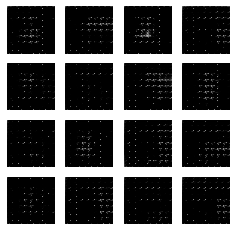

6 ... 
Total Loss : 61.24687194824219
Loss Critic : 110.5833740234375
Loss Generator : 171.8302459716797
7 ... 
Total Loss : 59.546600341796875
Loss Critic : 112.42477416992188
Loss Generator : 171.97137451171875
8 ... 
Total Loss : 63.00031280517578
Loss Critic : 113.27059173583984
Loss Generator : 176.27090454101562
9 ... 
Total Loss : 61.59442901611328
Loss Critic : 112.22650909423828
Loss Generator : 173.82093811035156
10 ... 
Total Loss : 61.114707946777344
Loss Critic : 114.32447052001953
Loss Generator : 175.43917846679688


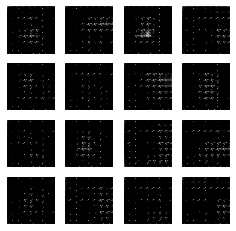

11 ... 
Total Loss : 61.639488220214844
Loss Critic : 114.31926727294922
Loss Generator : 175.95875549316406
12 ... 
Total Loss : 61.0601806640625
Loss Critic : 114.90449523925781
Loss Generator : 175.9646759033203
13 ... 
Total Loss : 59.22651672363281
Loss Critic : 117.20005798339844
Loss Generator : 176.42657470703125
14 ... 
Total Loss : 60.53753662109375
Loss Critic : 118.200927734375
Loss Generator : 178.73846435546875
15 ... 
Total Loss : 59.04212188720703
Loss Critic : 117.58312225341797
Loss Generator : 176.625244140625


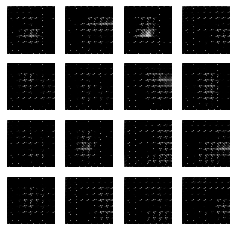

16 ... 
Total Loss : 60.31548309326172
Loss Critic : 119.41681671142578
Loss Generator : 179.7322998046875
17 ... 
Total Loss : 59.7935791015625
Loss Critic : 120.82061767578125
Loss Generator : 180.61419677734375
18 ... 
Total Loss : 60.232017517089844
Loss Critic : 120.49774932861328
Loss Generator : 180.72976684570312
19 ... 
Total Loss : 57.22468566894531
Loss Critic : 122.69439697265625
Loss Generator : 179.91908264160156
20 ... 
Total Loss : 56.05482482910156
Loss Critic : 123.28654479980469
Loss Generator : 179.34136962890625


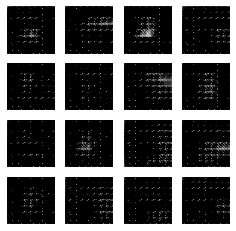

21 ... 
Total Loss : 57.353851318359375
Loss Critic : 122.16441345214844
Loss Generator : 179.5182647705078
22 ... 
Total Loss : 55.56244659423828
Loss Critic : 124.9529037475586
Loss Generator : 180.51535034179688
23 ... 
Total Loss : 55.19403076171875
Loss Critic : 120.45771789550781
Loss Generator : 175.65174865722656
24 ... 
Total Loss : 53.297454833984375
Loss Critic : 123.64100646972656
Loss Generator : 176.93846130371094
25 ... 
Total Loss : 54.4039306640625
Loss Critic : 126.23641967773438
Loss Generator : 180.64035034179688


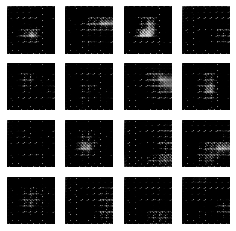

26 ... 
Total Loss : 49.44407653808594
Loss Critic : 132.42433166503906
Loss Generator : 181.868408203125
27 ... 
Total Loss : 51.56005859375
Loss Critic : 131.89190673828125
Loss Generator : 183.45196533203125
28 ... 
Total Loss : 50.454345703125
Loss Critic : 136.06544494628906
Loss Generator : 186.51979064941406
29 ... 
Total Loss : 47.61549377441406
Loss Critic : 135.4853973388672
Loss Generator : 183.10089111328125
30 ... 
Total Loss : 47.67628479003906
Loss Critic : 138.52601623535156
Loss Generator : 186.20230102539062


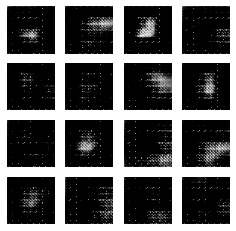

31 ... 
Total Loss : 43.79771423339844
Loss Critic : 144.0450897216797
Loss Generator : 187.84280395507812
32 ... 
Total Loss : 48.1295166015625
Loss Critic : 140.74075317382812
Loss Generator : 188.87026977539062
33 ... 
Total Loss : 47.49713134765625
Loss Critic : 139.67218017578125
Loss Generator : 187.1693115234375
34 ... 
Total Loss : 44.6802978515625
Loss Critic : 145.83541870117188
Loss Generator : 190.51571655273438
35 ... 
Total Loss : 44.463043212890625
Loss Critic : 143.52838134765625
Loss Generator : 187.99142456054688


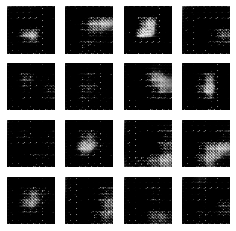

36 ... 
Total Loss : 45.4000244140625
Loss Critic : 146.64517211914062
Loss Generator : 192.04519653320312
37 ... 
Total Loss : 41.921295166015625
Loss Critic : 152.22500610351562
Loss Generator : 194.14630126953125
38 ... 
Total Loss : 42.68194580078125
Loss Critic : 150.68832397460938
Loss Generator : 193.37026977539062
39 ... 
Total Loss : 41.4210205078125
Loss Critic : 151.98220825195312
Loss Generator : 193.40322875976562
40 ... 
Total Loss : 38.35023498535156
Loss Critic : 158.0313262939453
Loss Generator : 196.38156127929688


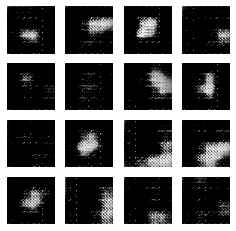

41 ... 
Total Loss : 41.9937744140625
Loss Critic : 155.2829132080078
Loss Generator : 197.2766876220703
42 ... 
Total Loss : 38.11260986328125
Loss Critic : 157.57986450195312
Loss Generator : 195.69247436523438
43 ... 
Total Loss : 37.12330627441406
Loss Critic : 159.60052490234375
Loss Generator : 196.7238311767578
44 ... 
Total Loss : 36.40113830566406
Loss Critic : 161.4468231201172
Loss Generator : 197.84796142578125
45 ... 
Total Loss : 36.64024353027344
Loss Critic : 162.31784057617188
Loss Generator : 198.9580841064453


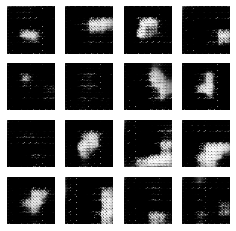

46 ... 
Total Loss : 33.63861083984375
Loss Critic : 161.9794921875
Loss Generator : 195.61810302734375
47 ... 
Total Loss : 36.08148193359375
Loss Critic : 158.79254150390625
Loss Generator : 194.8740234375
48 ... 
Total Loss : 34.126190185546875
Loss Critic : 164.0187225341797
Loss Generator : 198.14491271972656
49 ... 
Total Loss : 31.342803955078125
Loss Critic : 163.65652465820312
Loss Generator : 194.99932861328125
50 ... 
Total Loss : 35.328521728515625
Loss Critic : 162.38739013671875
Loss Generator : 197.71591186523438


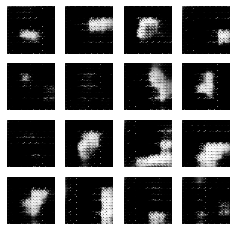

51 ... 
Total Loss : 31.403778076171875
Loss Critic : 164.78282165527344
Loss Generator : 196.1865997314453
52 ... 
Total Loss : 31.864501953125
Loss Critic : 167.01776123046875
Loss Generator : 198.88226318359375
53 ... 
Total Loss : 30.2989501953125
Loss Critic : 165.44212341308594
Loss Generator : 195.74107360839844
54 ... 
Total Loss : 31.237960815429688
Loss Critic : 164.78707885742188
Loss Generator : 196.02503967285156
55 ... 
Total Loss : 28.746322631835938
Loss Critic : 167.13031005859375
Loss Generator : 195.8766326904297


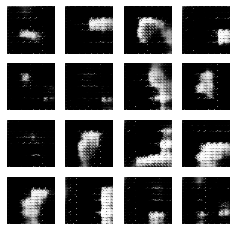

56 ... 
Total Loss : 30.203201293945312
Loss Critic : 169.294921875
Loss Generator : 199.4981231689453
57 ... 
Total Loss : 28.850616455078125
Loss Critic : 167.78778076171875
Loss Generator : 196.63839721679688
58 ... 
Total Loss : 29.171615600585938
Loss Critic : 171.2284698486328
Loss Generator : 200.40008544921875
59 ... 
Total Loss : 27.8497314453125
Loss Critic : 171.17886352539062
Loss Generator : 199.02859497070312
60 ... 
Total Loss : 27.159774780273438
Loss Critic : 172.78907775878906
Loss Generator : 199.9488525390625


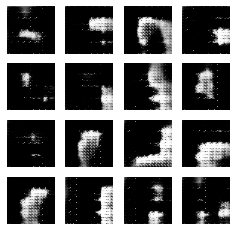

61 ... 
Total Loss : 27.296401977539062
Loss Critic : 176.3265838623047
Loss Generator : 203.62298583984375
62 ... 
Total Loss : 27.77069091796875
Loss Critic : 174.45367431640625
Loss Generator : 202.224365234375
63 ... 
Total Loss : 27.4183349609375
Loss Critic : 174.1602783203125
Loss Generator : 201.57861328125
64 ... 
Total Loss : 25.085418701171875
Loss Critic : 176.1759033203125
Loss Generator : 201.26132202148438
65 ... 
Total Loss : 27.94866943359375
Loss Critic : 175.771728515625
Loss Generator : 203.72039794921875


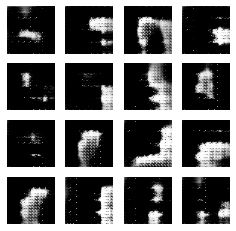

66 ... 
Total Loss : 29.435653686523438
Loss Critic : 176.94537353515625
Loss Generator : 206.3810272216797
67 ... 
Total Loss : 25.526763916015625
Loss Critic : 178.47262573242188
Loss Generator : 203.9993896484375
68 ... 
Total Loss : 26.0975341796875
Loss Critic : 177.33935546875
Loss Generator : 203.4368896484375
69 ... 
Total Loss : 25.796798706054688
Loss Critic : 177.66368103027344
Loss Generator : 203.46047973632812
70 ... 
Total Loss : 25.89447021484375
Loss Critic : 175.87481689453125
Loss Generator : 201.769287109375


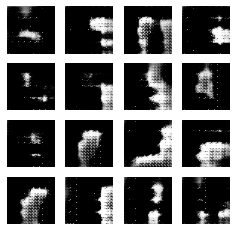

71 ... 
Total Loss : 26.643310546875
Loss Critic : 175.987548828125
Loss Generator : 202.630859375
72 ... 
Total Loss : 25.153274536132812
Loss Critic : 176.589599609375
Loss Generator : 201.7428741455078
73 ... 
Total Loss : 26.164108276367188
Loss Critic : 175.65675354003906
Loss Generator : 201.82086181640625
74 ... 
Total Loss : 24.595977783203125
Loss Critic : 173.89019775390625
Loss Generator : 198.48617553710938
75 ... 
Total Loss : 22.64239501953125
Loss Critic : 174.47540283203125
Loss Generator : 197.1177978515625


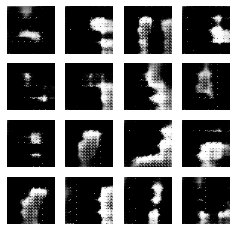

76 ... 
Total Loss : 23.137176513671875
Loss Critic : 177.10069274902344
Loss Generator : 200.2378692626953
77 ... 
Total Loss : 22.527145385742188
Loss Critic : 176.89097595214844
Loss Generator : 199.41812133789062
78 ... 
Total Loss : 23.48284912109375
Loss Critic : 176.48394775390625
Loss Generator : 199.966796875
79 ... 
Total Loss : 22.389968872070312
Loss Critic : 181.32444763183594
Loss Generator : 203.71441650390625
80 ... 
Total Loss : 23.729721069335938
Loss Critic : 177.8148193359375
Loss Generator : 201.54454040527344


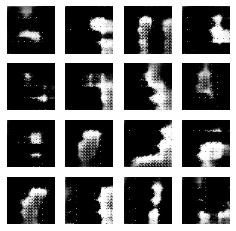

81 ... 
Total Loss : 23.71624755859375
Loss Critic : 180.09254455566406
Loss Generator : 203.8087921142578
82 ... 
Total Loss : 22.387481689453125
Loss Critic : 179.64578247070312
Loss Generator : 202.03326416015625
83 ... 
Total Loss : 22.382308959960938
Loss Critic : 183.74685668945312
Loss Generator : 206.12916564941406
84 ... 
Total Loss : 23.067626953125
Loss Critic : 184.29306030273438
Loss Generator : 207.36068725585938
85 ... 
Total Loss : 23.671676635742188
Loss Critic : 181.7639923095703
Loss Generator : 205.4356689453125


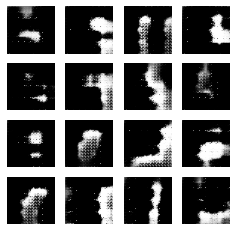

86 ... 
Total Loss : 20.65216064453125
Loss Critic : 180.12905883789062
Loss Generator : 200.78121948242188
87 ... 
Total Loss : 24.435348510742188
Loss Critic : 185.7404327392578
Loss Generator : 210.17578125
88 ... 
Total Loss : 23.652725219726562
Loss Critic : 177.7917938232422
Loss Generator : 201.44451904296875
89 ... 
Total Loss : 21.921600341796875
Loss Critic : 178.77120971679688
Loss Generator : 200.69281005859375
90 ... 
Total Loss : 20.067581176757812
Loss Critic : 179.34132385253906
Loss Generator : 199.40890502929688


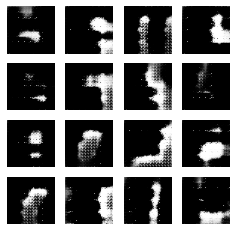

91 ... 
Total Loss : 21.646942138671875
Loss Critic : 179.49264526367188
Loss Generator : 201.13958740234375
92 ... 
Total Loss : 20.662765502929688
Loss Critic : 181.1810302734375
Loss Generator : 201.8437957763672
93 ... 
Total Loss : 21.853439331054688
Loss Critic : 182.05043029785156
Loss Generator : 203.90386962890625
94 ... 
Total Loss : 22.094985961914062
Loss Critic : 180.104736328125
Loss Generator : 202.19972229003906
95 ... 
Total Loss : 22.624191284179688
Loss Critic : 182.71920776367188
Loss Generator : 205.34339904785156


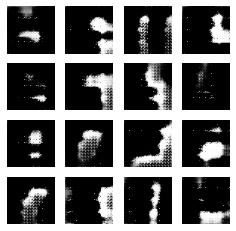

96 ... 
Total Loss : 21.549636840820312
Loss Critic : 181.1405029296875
Loss Generator : 202.6901397705078
97 ... 
Total Loss : 20.032257080078125
Loss Critic : 184.21421813964844
Loss Generator : 204.24647521972656
98 ... 
Total Loss : 22.094558715820312
Loss Critic : 183.40000915527344
Loss Generator : 205.49456787109375
99 ... 
Total Loss : 21.039962768554688
Loss Critic : 180.19940185546875
Loss Generator : 201.23936462402344
100 ... 
Total Loss : 21.2589111328125
Loss Critic : 185.06883239746094
Loss Generator : 206.32774353027344


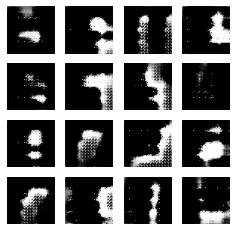

101 ... 
Total Loss : 21.466506958007812
Loss Critic : 183.34091186523438
Loss Generator : 204.8074188232422
102 ... 
Total Loss : 21.965713500976562
Loss Critic : 181.6219482421875
Loss Generator : 203.58766174316406
103 ... 
Total Loss : 20.328414916992188
Loss Critic : 188.11611938476562
Loss Generator : 208.4445343017578
104 ... 
Total Loss : 18.370849609375
Loss Critic : 188.95071411132812
Loss Generator : 207.32156372070312
105 ... 
Total Loss : 19.842437744140625
Loss Critic : 187.9026336669922
Loss Generator : 207.7450714111328


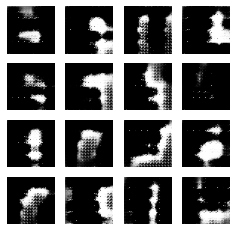

106 ... 
Total Loss : 19.361572265625
Loss Critic : 184.80126953125
Loss Generator : 204.162841796875
107 ... 
Total Loss : 20.129226684570312
Loss Critic : 186.7733917236328
Loss Generator : 206.90261840820312
108 ... 
Total Loss : 19.25433349609375
Loss Critic : 185.1339111328125
Loss Generator : 204.38824462890625
109 ... 
Total Loss : 18.796951293945312
Loss Critic : 184.32884216308594
Loss Generator : 203.12579345703125
110 ... 
Total Loss : 21.8731689453125
Loss Critic : 184.77505493164062
Loss Generator : 206.64822387695312


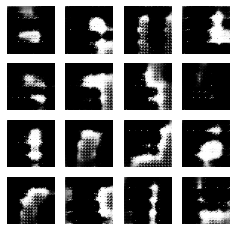

111 ... 
Total Loss : 19.697784423828125
Loss Critic : 187.69998168945312
Loss Generator : 207.39776611328125
112 ... 
Total Loss : 20.171493530273438
Loss Critic : 182.0371856689453
Loss Generator : 202.20867919921875
113 ... 
Total Loss : 19.358413696289062
Loss Critic : 185.9412384033203
Loss Generator : 205.29965209960938
114 ... 
Total Loss : 19.456985473632812
Loss Critic : 181.38575744628906
Loss Generator : 200.84274291992188
115 ... 
Total Loss : 21.920974731445312
Loss Critic : 182.99240112304688
Loss Generator : 204.9133758544922


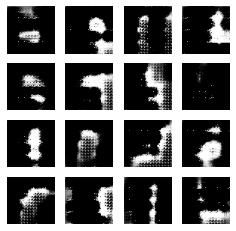

116 ... 
Total Loss : 18.516815185546875
Loss Critic : 178.73648071289062
Loss Generator : 197.2532958984375
117 ... 
Total Loss : 20.8336181640625
Loss Critic : 179.64797973632812
Loss Generator : 200.48159790039062
118 ... 
Total Loss : 20.861785888671875
Loss Critic : 183.71609497070312
Loss Generator : 204.577880859375
119 ... 
Total Loss : 20.662155151367188
Loss Critic : 182.5024871826172
Loss Generator : 203.16464233398438
120 ... 
Total Loss : 19.480926513671875
Loss Critic : 180.62399291992188
Loss Generator : 200.10491943359375


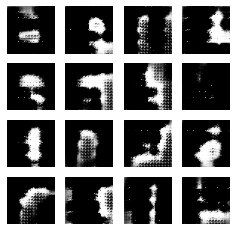

121 ... 
Total Loss : 17.013290405273438
Loss Critic : 184.81661987304688
Loss Generator : 201.8299102783203
122 ... 
Total Loss : 18.1143798828125
Loss Critic : 182.74810791015625
Loss Generator : 200.86248779296875
123 ... 
Total Loss : 21.44281005859375
Loss Critic : 184.41160583496094
Loss Generator : 205.8544158935547
124 ... 
Total Loss : 19.041397094726562
Loss Critic : 187.29507446289062
Loss Generator : 206.3364715576172
125 ... 
Total Loss : 18.923309326171875
Loss Critic : 186.34054565429688
Loss Generator : 205.26385498046875


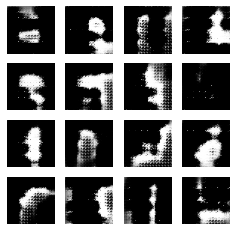

126 ... 
Total Loss : 20.181198120117188
Loss Critic : 183.51126098632812
Loss Generator : 203.6924591064453
127 ... 
Total Loss : 18.200164794921875
Loss Critic : 190.9163055419922
Loss Generator : 209.11647033691406
128 ... 
Total Loss : 22.16949462890625
Loss Critic : 192.02392578125
Loss Generator : 214.19342041015625
129 ... 
Total Loss : 19.699539184570312
Loss Critic : 190.45201110839844
Loss Generator : 210.15155029296875
130 ... 
Total Loss : 18.621841430664062
Loss Critic : 190.11935424804688
Loss Generator : 208.74119567871094


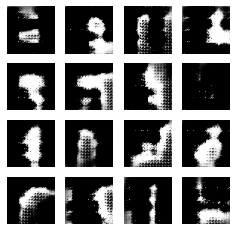

131 ... 
Total Loss : 18.67706298828125
Loss Critic : 190.34432983398438
Loss Generator : 209.02139282226562
132 ... 
Total Loss : 19.213241577148438
Loss Critic : 194.0601348876953
Loss Generator : 213.27337646484375
133 ... 
Total Loss : 19.4969482421875
Loss Critic : 188.79678344726562
Loss Generator : 208.29373168945312
134 ... 
Total Loss : 18.330001831054688
Loss Critic : 189.41281127929688
Loss Generator : 207.74281311035156
135 ... 
Total Loss : 18.840469360351562
Loss Critic : 188.1820068359375
Loss Generator : 207.02247619628906


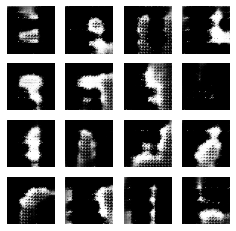

136 ... 
Total Loss : 19.271347045898438
Loss Critic : 178.33975219726562
Loss Generator : 197.61109924316406
137 ... 
Total Loss : 17.406204223632812
Loss Critic : 180.2706298828125
Loss Generator : 197.6768341064453
138 ... 
Total Loss : 17.529586791992188
Loss Critic : 178.94241333007812
Loss Generator : 196.4720001220703
139 ... 
Total Loss : 19.554000854492188
Loss Critic : 178.15701293945312
Loss Generator : 197.7110137939453
140 ... 
Total Loss : 16.400192260742188
Loss Critic : 181.12803649902344
Loss Generator : 197.52822875976562


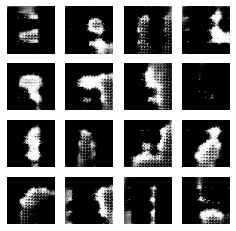

141 ... 
Total Loss : 18.270980834960938
Loss Critic : 181.4580078125
Loss Generator : 199.72898864746094
142 ... 
Total Loss : 16.518478393554688
Loss Critic : 185.72442626953125
Loss Generator : 202.24290466308594
143 ... 
Total Loss : 18.803604125976562
Loss Critic : 181.23739624023438
Loss Generator : 200.04100036621094
144 ... 
Total Loss : 14.212982177734375
Loss Critic : 179.30438232421875
Loss Generator : 193.51736450195312
145 ... 
Total Loss : 14.155242919921875
Loss Critic : 184.3677520751953
Loss Generator : 198.5229949951172


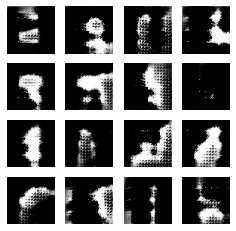

146 ... 
Total Loss : 16.616867065429688
Loss Critic : 188.072509765625
Loss Generator : 204.6893768310547
147 ... 
Total Loss : 16.398941040039062
Loss Critic : 185.2811279296875
Loss Generator : 201.68006896972656
148 ... 
Total Loss : 18.542999267578125
Loss Critic : 189.0460205078125
Loss Generator : 207.58901977539062
149 ... 
Total Loss : 16.802276611328125
Loss Critic : 189.3919677734375
Loss Generator : 206.19424438476562
====== Epoch  4 ======
0 ... 
Total Loss : 16.86151123046875
Loss Critic : 189.31961059570312
Loss Generator : 206.18112182617188
1 ... 
Total Loss : 18.868850708007812
Loss Critic : 192.91213989257812
Loss Generator : 211.78099060058594
2 ... 
Total Loss : 17.1146240234375
Loss Critic : 189.30032348632812
Loss Generator : 206.41494750976562
3 ... 
Total Loss : 16.307022094726562
Loss Critic : 188.00604248046875
Loss Generator : 204.3130645751953
4 ... 
Total Loss : 17.762863159179688
Loss Critic : 191.16172790527344
Loss Generator : 208.92459106445312
5 ... 


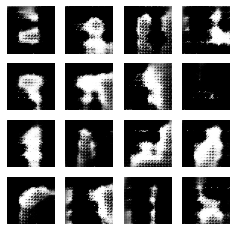

6 ... 
Total Loss : 17.849334716796875
Loss Critic : 192.7149658203125
Loss Generator : 210.56430053710938
7 ... 
Total Loss : 15.606735229492188
Loss Critic : 191.3599853515625
Loss Generator : 206.9667205810547
8 ... 
Total Loss : 17.43609619140625
Loss Critic : 192.35256958007812
Loss Generator : 209.78866577148438
9 ... 
Total Loss : 17.514541625976562
Loss Critic : 190.55528259277344
Loss Generator : 208.06982421875
10 ... 
Total Loss : 15.53863525390625
Loss Critic : 189.47061157226562
Loss Generator : 205.00924682617188


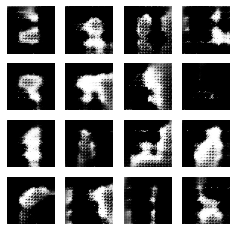

11 ... 
Total Loss : 16.87652587890625
Loss Critic : 188.466064453125
Loss Generator : 205.34259033203125
12 ... 
Total Loss : 13.32037353515625
Loss Critic : 181.89871215820312
Loss Generator : 195.21908569335938
13 ... 
Total Loss : 14.044570922851562
Loss Critic : 185.57933044433594
Loss Generator : 199.6239013671875
14 ... 
Total Loss : 16.324325561523438
Loss Critic : 187.83692932128906
Loss Generator : 204.1612548828125
15 ... 
Total Loss : 15.972091674804688
Loss Critic : 180.41310119628906
Loss Generator : 196.38519287109375


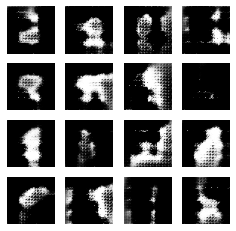

16 ... 
Total Loss : 12.93756103515625
Loss Critic : 186.157470703125
Loss Generator : 199.09503173828125
17 ... 
Total Loss : 14.473464965820312
Loss Critic : 184.21347045898438
Loss Generator : 198.6869354248047
18 ... 
Total Loss : 14.260879516601562
Loss Critic : 183.1763916015625
Loss Generator : 197.43727111816406
19 ... 
Total Loss : 14.299270629882812
Loss Critic : 188.34393310546875
Loss Generator : 202.64320373535156
20 ... 
Total Loss : 14.223800659179688
Loss Critic : 187.1488037109375
Loss Generator : 201.3726043701172


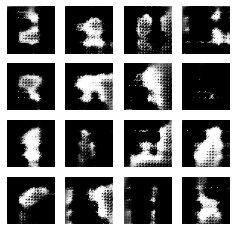

21 ... 
Total Loss : 15.882965087890625
Loss Critic : 188.21194458007812
Loss Generator : 204.09490966796875
22 ... 
Total Loss : 14.512786865234375
Loss Critic : 190.46710205078125
Loss Generator : 204.97988891601562
23 ... 
Total Loss : 15.49700927734375
Loss Critic : 190.88864135742188
Loss Generator : 206.38565063476562
24 ... 
Total Loss : 14.160003662109375
Loss Critic : 188.23284912109375
Loss Generator : 202.39285278320312
25 ... 
Total Loss : 12.454605102539062
Loss Critic : 189.4874725341797
Loss Generator : 201.94207763671875


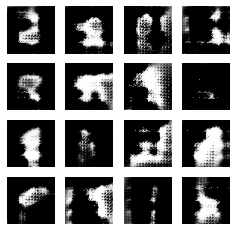

26 ... 
Total Loss : 14.843215942382812
Loss Critic : 186.06121826171875
Loss Generator : 200.90443420410156
27 ... 
Total Loss : 14.587936401367188
Loss Critic : 190.19906616210938
Loss Generator : 204.78700256347656
28 ... 
Total Loss : 13.674331665039062
Loss Critic : 187.55575561523438
Loss Generator : 201.23008728027344
29 ... 
Total Loss : 13.30792236328125
Loss Critic : 188.17584228515625
Loss Generator : 201.4837646484375
30 ... 
Total Loss : 11.737106323242188
Loss Critic : 184.7975311279297
Loss Generator : 196.53463745117188


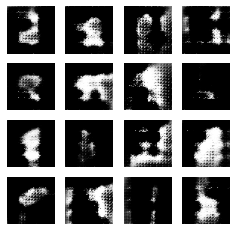

31 ... 
Total Loss : 14.116851806640625
Loss Critic : 179.464111328125
Loss Generator : 193.58096313476562
32 ... 
Total Loss : 15.55645751953125
Loss Critic : 185.89205932617188
Loss Generator : 201.44851684570312
33 ... 
Total Loss : 12.929550170898438
Loss Critic : 176.96133422851562
Loss Generator : 189.89088439941406
34 ... 
Total Loss : 14.361984252929688
Loss Critic : 188.81817626953125
Loss Generator : 203.18016052246094
35 ... 
Total Loss : 11.665451049804688
Loss Critic : 184.2045440673828
Loss Generator : 195.8699951171875


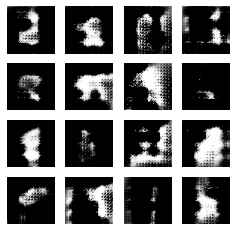

36 ... 
Total Loss : 11.827194213867188
Loss Critic : 183.18426513671875
Loss Generator : 195.01145935058594
37 ... 
Total Loss : 14.462860107421875
Loss Critic : 185.666259765625
Loss Generator : 200.12911987304688
38 ... 
Total Loss : 11.930313110351562
Loss Critic : 185.52337646484375
Loss Generator : 197.4536895751953
39 ... 
Total Loss : 11.0546875
Loss Critic : 187.8060302734375
Loss Generator : 198.8607177734375
40 ... 
Total Loss : 12.64031982421875
Loss Critic : 184.00531005859375
Loss Generator : 196.6456298828125


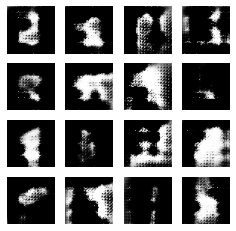

41 ... 
Total Loss : 12.781951904296875
Loss Critic : 185.78594970703125
Loss Generator : 198.56790161132812
42 ... 
Total Loss : 12.020965576171875
Loss Critic : 186.67950439453125
Loss Generator : 198.70046997070312
43 ... 
Total Loss : 11.71783447265625
Loss Critic : 188.29705810546875
Loss Generator : 200.014892578125
44 ... 
Total Loss : 13.533294677734375
Loss Critic : 190.73834228515625
Loss Generator : 204.27163696289062
45 ... 
Total Loss : 14.235153198242188
Loss Critic : 189.60833740234375
Loss Generator : 203.84349060058594


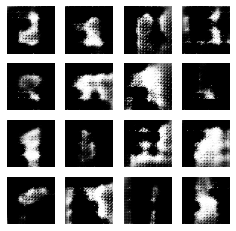

46 ... 
Total Loss : 10.308822631835938
Loss Critic : 186.15536499023438
Loss Generator : 196.4641876220703
47 ... 
Total Loss : 11.526901245117188
Loss Critic : 183.54782104492188
Loss Generator : 195.07472229003906
48 ... 
Total Loss : 10.93658447265625
Loss Critic : 184.55075073242188
Loss Generator : 195.48733520507812
49 ... 
Total Loss : 12.098876953125
Loss Critic : 183.9648895263672
Loss Generator : 196.0637664794922
50 ... 
Total Loss : 12.064666748046875
Loss Critic : 180.65982055664062
Loss Generator : 192.7244873046875


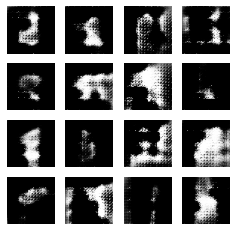

51 ... 
Total Loss : 10.838455200195312
Loss Critic : 180.1415557861328
Loss Generator : 190.98001098632812
52 ... 
Total Loss : 10.959671020507812
Loss Critic : 185.37164306640625
Loss Generator : 196.33131408691406
53 ... 
Total Loss : 10.485580444335938
Loss Critic : 188.47998046875
Loss Generator : 198.96556091308594
54 ... 
Total Loss : 10.938079833984375
Loss Critic : 185.60882568359375
Loss Generator : 196.54690551757812
55 ... 
Total Loss : 8.835968017578125
Loss Critic : 190.77047729492188
Loss Generator : 199.6064453125


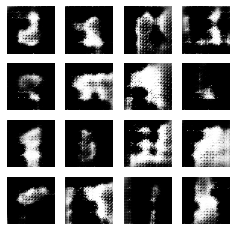

56 ... 
Total Loss : 10.631561279296875
Loss Critic : 188.0919189453125
Loss Generator : 198.72348022460938
57 ... 
Total Loss : 8.626663208007812
Loss Critic : 187.75204467773438
Loss Generator : 196.3787078857422
58 ... 
Total Loss : 13.447662353515625
Loss Critic : 194.22091674804688
Loss Generator : 207.6685791015625
59 ... 
Total Loss : 13.557785034179688
Loss Critic : 191.03207397460938
Loss Generator : 204.58985900878906
60 ... 
Total Loss : 11.514617919921875
Loss Critic : 193.97511291503906
Loss Generator : 205.48973083496094


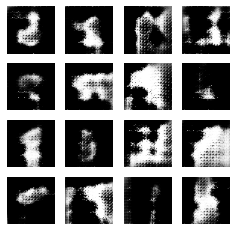

61 ... 
Total Loss : 10.228866577148438
Loss Critic : 191.0966033935547
Loss Generator : 201.32546997070312
62 ... 
Total Loss : 8.100311279296875
Loss Critic : 186.40402221679688
Loss Generator : 194.50433349609375
63 ... 
Total Loss : 10.2001953125
Loss Critic : 193.43698120117188
Loss Generator : 203.63717651367188
64 ... 
Total Loss : 8.71966552734375
Loss Critic : 181.77593994140625
Loss Generator : 190.49560546875
65 ... 
Total Loss : 10.491287231445312
Loss Critic : 186.97463989257812
Loss Generator : 197.46592712402344


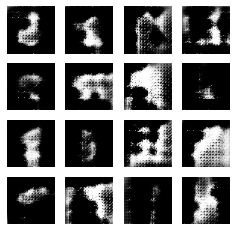

66 ... 
Total Loss : 10.576339721679688
Loss Critic : 185.52490234375
Loss Generator : 196.1012420654297
67 ... 
Total Loss : 11.728485107421875
Loss Critic : 182.61636352539062
Loss Generator : 194.3448486328125
68 ... 
Total Loss : 11.061325073242188
Loss Critic : 177.6184844970703
Loss Generator : 188.6798095703125
69 ... 
Total Loss : 9.593780517578125
Loss Critic : 177.57794189453125
Loss Generator : 187.17172241210938
70 ... 
Total Loss : 7.669769287109375
Loss Critic : 183.9447021484375
Loss Generator : 191.61447143554688


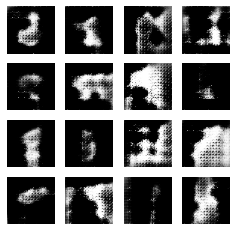

71 ... 
Total Loss : 7.8967132568359375
Loss Critic : 182.98428344726562
Loss Generator : 190.88099670410156
72 ... 
Total Loss : 5.7372589111328125
Loss Critic : 186.30345153808594
Loss Generator : 192.04071044921875
73 ... 
Total Loss : 10.01312255859375
Loss Critic : 191.31118774414062
Loss Generator : 201.32431030273438
74 ... 
Total Loss : 7.637969970703125
Loss Critic : 185.32879638671875
Loss Generator : 192.96676635742188
75 ... 
Total Loss : 7.941497802734375
Loss Critic : 187.57662963867188
Loss Generator : 195.51812744140625


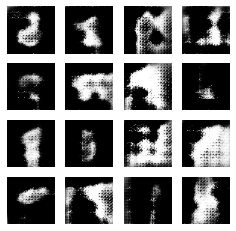

76 ... 
Total Loss : 9.5579833984375
Loss Critic : 190.29043579101562
Loss Generator : 199.84841918945312
77 ... 
Total Loss : 7.9632415771484375
Loss Critic : 186.9263916015625
Loss Generator : 194.88963317871094
78 ... 
Total Loss : 10.653793334960938
Loss Critic : 190.798095703125
Loss Generator : 201.45188903808594
79 ... 
Total Loss : 7.516632080078125
Loss Critic : 183.79336547851562
Loss Generator : 191.30999755859375
80 ... 
Total Loss : 7.2727813720703125
Loss Critic : 188.0676727294922
Loss Generator : 195.3404541015625


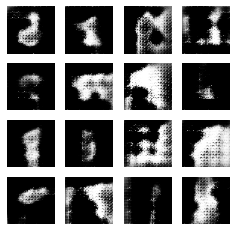

81 ... 
Total Loss : 7.77484130859375
Loss Critic : 187.5220947265625
Loss Generator : 195.29693603515625
82 ... 
Total Loss : 10.8226318359375
Loss Critic : 173.30178833007812
Loss Generator : 184.12442016601562
83 ... 
Total Loss : 10.96258544921875
Loss Critic : 175.23068237304688
Loss Generator : 186.19326782226562
84 ... 
Total Loss : 9.175079345703125
Loss Critic : 175.64260864257812
Loss Generator : 184.81768798828125
85 ... 
Total Loss : 8.156265258789062
Loss Critic : 176.93350219726562
Loss Generator : 185.0897674560547


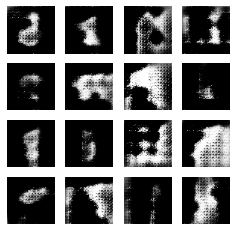

86 ... 
Total Loss : 8.116058349609375
Loss Critic : 179.4373779296875
Loss Generator : 187.55343627929688
87 ... 
Total Loss : 9.022567749023438
Loss Critic : 179.98402404785156
Loss Generator : 189.006591796875
88 ... 
Total Loss : 7.3303070068359375
Loss Critic : 189.14161682128906
Loss Generator : 196.471923828125
89 ... 
Total Loss : 8.105545043945312
Loss Critic : 189.39193725585938
Loss Generator : 197.4974822998047
90 ... 
Total Loss : 8.623382568359375
Loss Critic : 185.5240478515625
Loss Generator : 194.14743041992188


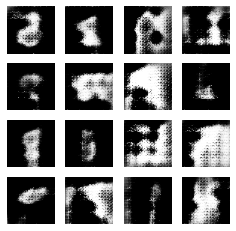

91 ... 
Total Loss : 6.15362548828125
Loss Critic : 188.9891357421875
Loss Generator : 195.14276123046875
92 ... 
Total Loss : 8.729965209960938
Loss Critic : 193.42385864257812
Loss Generator : 202.15382385253906
93 ... 
Total Loss : 7.6782989501953125
Loss Critic : 192.6771240234375
Loss Generator : 200.3554229736328
94 ... 
Total Loss : 7.9171142578125
Loss Critic : 189.8497314453125
Loss Generator : 197.766845703125
95 ... 
Total Loss : 5.2958526611328125
Loss Critic : 184.53590393066406
Loss Generator : 189.83175659179688


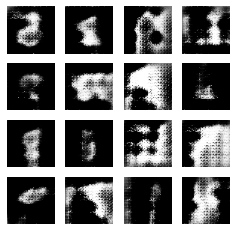

96 ... 
Total Loss : 7.4740447998046875
Loss Critic : 183.02647399902344
Loss Generator : 190.50051879882812
97 ... 
Total Loss : 6.041015625
Loss Critic : 184.80560302734375
Loss Generator : 190.84661865234375
98 ... 
Total Loss : 5.87677001953125
Loss Critic : 183.56427001953125
Loss Generator : 189.4410400390625
99 ... 
Total Loss : 6.369110107421875
Loss Critic : 181.67547607421875
Loss Generator : 188.04458618164062
100 ... 
Total Loss : 5.5872650146484375
Loss Critic : 189.66754150390625
Loss Generator : 195.2548065185547


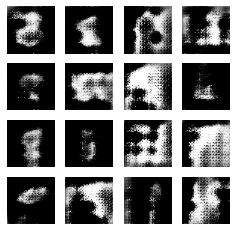

101 ... 
Total Loss : 3.7925567626953125
Loss Critic : 185.47918701171875
Loss Generator : 189.27174377441406
102 ... 
Total Loss : 5.9114227294921875
Loss Critic : 192.5599365234375
Loss Generator : 198.4713592529297
103 ... 
Total Loss : 4.744659423828125
Loss Critic : 188.3997039794922
Loss Generator : 193.1443634033203
104 ... 
Total Loss : 4.1357421875
Loss Critic : 189.16195678710938
Loss Generator : 193.29769897460938
105 ... 
Total Loss : 4.7093505859375
Loss Critic : 185.814453125
Loss Generator : 190.5238037109375


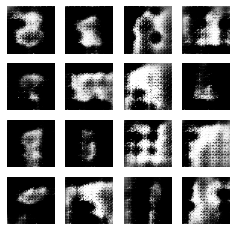

106 ... 
Total Loss : 4.2788238525390625
Loss Critic : 184.2091827392578
Loss Generator : 188.48800659179688
107 ... 
Total Loss : 3.666717529296875
Loss Critic : 184.5618896484375
Loss Generator : 188.22860717773438
108 ... 
Total Loss : 4.4983367919921875
Loss Critic : 185.437744140625
Loss Generator : 189.9360809326172
109 ... 
Total Loss : 4.164794921875
Loss Critic : 187.5549774169922
Loss Generator : 191.7197723388672
110 ... 
Total Loss : 3.1712799072265625
Loss Critic : 184.0904541015625
Loss Generator : 187.26173400878906


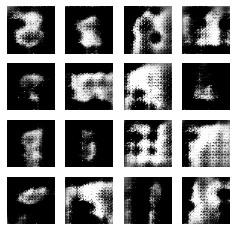

111 ... 
Total Loss : 5.6926422119140625
Loss Critic : 190.01284790039062
Loss Generator : 195.7054901123047
112 ... 
Total Loss : 3.1312255859375
Loss Critic : 185.29287719726562
Loss Generator : 188.42410278320312
113 ... 
Total Loss : 3.919830322265625
Loss Critic : 188.19515991210938
Loss Generator : 192.114990234375
114 ... 
Total Loss : 6.095001220703125
Loss Critic : 189.97598266601562
Loss Generator : 196.07098388671875
115 ... 
Total Loss : 3.1139068603515625
Loss Critic : 184.53424072265625
Loss Generator : 187.6481475830078


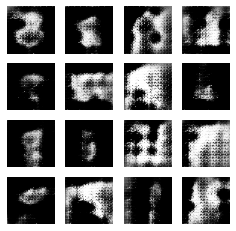

116 ... 
Total Loss : 3.8564605712890625
Loss Critic : 187.67520141601562
Loss Generator : 191.5316619873047
117 ... 
Total Loss : 4.1646575927734375
Loss Critic : 184.85504150390625
Loss Generator : 189.0196990966797
118 ... 
Total Loss : 3.3698272705078125
Loss Critic : 185.2779541015625
Loss Generator : 188.6477813720703
119 ... 
Total Loss : 5.309783935546875
Loss Critic : 182.86444091796875
Loss Generator : 188.17422485351562
120 ... 
Total Loss : 6.0523834228515625
Loss Critic : 187.14663696289062
Loss Generator : 193.1990203857422


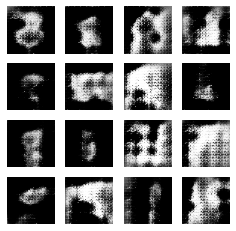

121 ... 
Total Loss : 4.443817138671875
Loss Critic : 190.36737060546875
Loss Generator : 194.81118774414062
122 ... 
Total Loss : 3.64373779296875
Loss Critic : 186.2061309814453
Loss Generator : 189.84986877441406
123 ... 
Total Loss : 3.5033721923828125
Loss Critic : 187.9463348388672
Loss Generator : 191.44970703125
124 ... 
Total Loss : 3.380859375
Loss Critic : 187.1808319091797
Loss Generator : 190.5616912841797
125 ... 
Total Loss : 2.4066009521484375
Loss Critic : 188.20701599121094
Loss Generator : 190.61361694335938


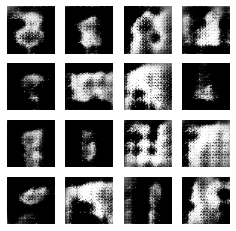

126 ... 
Total Loss : 1.154815673828125
Loss Critic : 184.73040771484375
Loss Generator : 185.88522338867188
127 ... 
Total Loss : 2.7028961181640625
Loss Critic : 187.75814819335938
Loss Generator : 190.46104431152344
128 ... 
Total Loss : 2.6915740966796875
Loss Critic : 189.2596435546875
Loss Generator : 191.9512176513672
129 ... 
Total Loss : 1.9892425537109375
Loss Critic : 186.96804809570312
Loss Generator : 188.95729064941406
130 ... 
Total Loss : 2.587127685546875
Loss Critic : 189.8562469482422
Loss Generator : 192.44337463378906


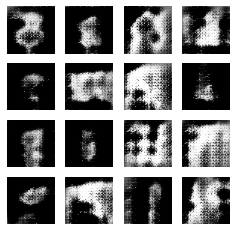

131 ... 
Total Loss : 3.132659912109375
Loss Critic : 191.31634521484375
Loss Generator : 194.44900512695312
132 ... 
Total Loss : 1.741180419921875
Loss Critic : 188.97015380859375
Loss Generator : 190.71133422851562
133 ... 
Total Loss : 3.1643218994140625
Loss Critic : 188.0167236328125
Loss Generator : 191.18104553222656
134 ... 
Total Loss : 1.85614013671875
Loss Critic : 189.121826171875
Loss Generator : 190.97796630859375
135 ... 
Total Loss : 0.8045196533203125
Loss Critic : 185.81663513183594
Loss Generator : 186.62115478515625


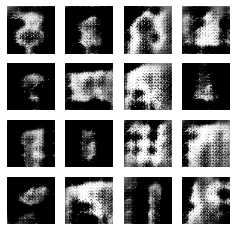

136 ... 
Total Loss : 2.6407012939453125
Loss Critic : 189.52357482910156
Loss Generator : 192.16427612304688
137 ... 
Total Loss : 0.730865478515625
Loss Critic : 186.32696533203125
Loss Generator : 187.05783081054688
138 ... 
Total Loss : 0.476959228515625
Loss Critic : 183.16159057617188
Loss Generator : 183.6385498046875
139 ... 
Total Loss : 2.4839630126953125
Loss Critic : 187.25926208496094
Loss Generator : 189.74322509765625
140 ... 
Total Loss : 0.33685302734375
Loss Critic : 189.22994995117188
Loss Generator : 189.56680297851562


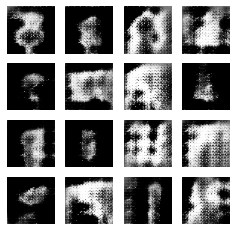

141 ... 
Total Loss : 1.4081268310546875
Loss Critic : 190.52755737304688
Loss Generator : 191.93568420410156
142 ... 
Total Loss : -0.3272247314453125
Loss Critic : 188.64022827148438
Loss Generator : 188.31300354003906
143 ... 
Total Loss : 2.301605224609375
Loss Critic : 191.73214721679688
Loss Generator : 194.03375244140625
144 ... 
Total Loss : -0.196380615234375
Loss Critic : 186.67727661132812
Loss Generator : 186.48089599609375
145 ... 
Total Loss : 0.66845703125
Loss Critic : 186.495361328125
Loss Generator : 187.163818359375


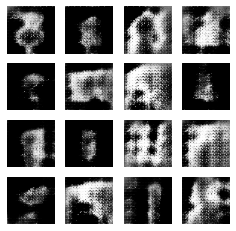

146 ... 
Total Loss : 1.2632598876953125
Loss Critic : 177.58554077148438
Loss Generator : 178.8488006591797
147 ... 
Total Loss : 0.355987548828125
Loss Critic : 187.91104125976562
Loss Generator : 188.26702880859375
148 ... 
Total Loss : 0.3687744140625
Loss Critic : 181.29151916503906
Loss Generator : 181.66029357910156
149 ... 
Total Loss : 0.756439208984375
Loss Critic : 185.2806396484375
Loss Generator : 186.03707885742188
====== Epoch  5 ======
0 ... 
Total Loss : -1.7435150146484375
Loss Critic : 181.03334045410156
Loss Generator : 179.28982543945312
1 ... 
Total Loss : 0.04034423828125
Loss Critic : 183.4046630859375
Loss Generator : 183.44500732421875
2 ... 
Total Loss : 1.0278167724609375
Loss Critic : 182.831787109375
Loss Generator : 183.85960388183594
3 ... 
Total Loss : 1.52557373046875
Loss Critic : 183.2725372314453
Loss Generator : 184.79811096191406
4 ... 
Total Loss : 2.2907257080078125
Loss Critic : 188.568603515625
Loss Generator : 190.8593292236328
5 ... 
Total L

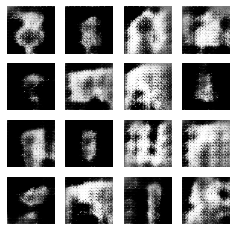

6 ... 
Total Loss : 1.2069244384765625
Loss Critic : 188.04629516601562
Loss Generator : 189.2532196044922
7 ... 
Total Loss : -0.8316802978515625
Loss Critic : 180.32650756835938
Loss Generator : 179.4948272705078
8 ... 
Total Loss : 0.15179443359375
Loss Critic : 188.22390747070312
Loss Generator : 188.37570190429688
9 ... 
Total Loss : -0.0995635986328125
Loss Critic : 187.62461853027344
Loss Generator : 187.52505493164062
10 ... 
Total Loss : -0.241424560546875
Loss Critic : 184.81056213378906
Loss Generator : 184.5691375732422


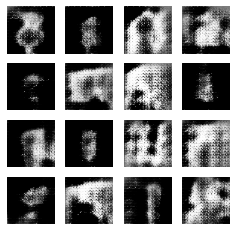

11 ... 
Total Loss : -0.3827972412109375
Loss Critic : 179.40670776367188
Loss Generator : 179.02391052246094
12 ... 
Total Loss : -0.752655029296875
Loss Critic : 185.22894287109375
Loss Generator : 184.47628784179688
13 ... 
Total Loss : 0.231414794921875
Loss Critic : 183.35079956054688
Loss Generator : 183.58221435546875
14 ... 
Total Loss : -0.99688720703125
Loss Critic : 183.15988159179688
Loss Generator : 182.16299438476562
15 ... 
Total Loss : -1.32745361328125
Loss Critic : 179.31442260742188
Loss Generator : 177.98696899414062


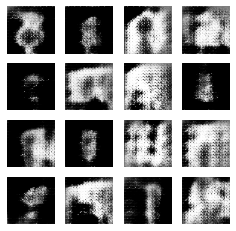

16 ... 
Total Loss : -2.2279052734375
Loss Critic : 186.34307861328125
Loss Generator : 184.11517333984375
17 ... 
Total Loss : -2.6600494384765625
Loss Critic : 188.17124938964844
Loss Generator : 185.51119995117188
18 ... 
Total Loss : -3.807159423828125
Loss Critic : 179.02685546875
Loss Generator : 175.21969604492188
19 ... 
Total Loss : 0.4129486083984375
Loss Critic : 186.75027465820312
Loss Generator : 187.16322326660156
20 ... 
Total Loss : -0.2263641357421875
Loss Critic : 186.2340087890625
Loss Generator : 186.0076446533203


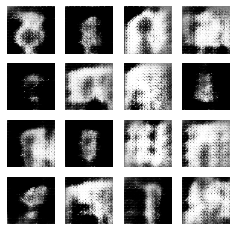

21 ... 
Total Loss : 1.2918243408203125
Loss Critic : 189.27685546875
Loss Generator : 190.5686798095703
22 ... 
Total Loss : -5.126129150390625
Loss Critic : 184.11203002929688
Loss Generator : 178.98590087890625
23 ... 
Total Loss : -3.65167236328125
Loss Critic : 188.13909912109375
Loss Generator : 184.4874267578125
24 ... 
Total Loss : -3.3705596923828125
Loss Critic : 183.71542358398438
Loss Generator : 180.34486389160156
25 ... 
Total Loss : -2.9144134521484375
Loss Critic : 186.03634643554688
Loss Generator : 183.12193298339844


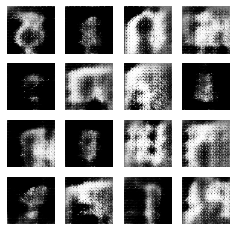

26 ... 
Total Loss : -1.477783203125
Loss Critic : 184.04376220703125
Loss Generator : 182.56597900390625
27 ... 

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.optimizers import Adam

# Parameters of the training
n_gen = 3                       # Updating the generator every x iterations
epochs = 10                     # Number of epochs
batch_size = 200                # Batch size
size = images.shape[0]
n = 60000                       # Number of observations used
lr = 1e-3                       # Learning rate
beta1 = 0.9
beta2 = 0.999
epsilon = 0.01                  # Regularization parameter

# Defining our optimizers
optimizer_c = Adam(learning_rate=lr, beta_1=beta1, beta_2=beta2)
optimizer_g = Adam(learning_rate=lr, beta_1=beta1, beta_2=beta2)

# Preparing the data into batches
images_data = tf.data.Dataset.from_tensor_slices(images[:n]).shuffle(size).batch(batch_size*2, drop_remainder=True)

# Defining a random noise that will be used throughout training
seed = tf.random.uniform(shape=(batch_size,1,1,2048), minval=-1, maxval=1)

for epoch in range(epochs):
    print("====== Epoch {:2d} ======".format(epoch))

    for i, real_images in enumerate(images_data):
        print(i, end=" ... ")

        # Splitting the batch into two parts
        X1 = real_images[:batch_size]
        X2 = real_images[batch_size:]

        # Deciding when to update the generator
        if i % n_gen == 0 and i > 0:
            update_gen = True
        else:
            update_gen = False
        
        # Running the train loop
        total_loss, loss_critic, loss_generator = train_OTGAN(X1, X2, update_gen=update_gen)

        print('\nTotal Loss : {}'.format(total_loss.numpy()))
        print('Loss Critic : {}'.format(loss_critic.numpy()))
        print('Loss Generator : {}'.format(loss_generator.numpy()))

        # Displaying the results
        if i % 5 == 0 and i > 0:
            generate_and_save_images(generator, epoch*1000 + i + 1, seed)

We can see that the generator produces some shapes. Eventhough these are not numbers this is an encouraging result. We are confident that with more time and more computational power we can reach an equilibrium between the generator and the critic that would eventually led to the re-production of MNIST numbers.

# Other model

Because the first model didn't perform as well as expected we wanted to propose a second model (based on the article "Learning Generative Models with Sinkhorn Divergences") without training it.

In [ ]:
images2 = x

In [ ]:
images2 = (images2 - 127.5) / 127.5

In [ ]:
images2 = tf.cast(images2, dtype=tf.float32)

In [ ]:
# More traditional MLP with two fully connected linear layers

def generator2():
    input_noise = Input(shape=(1, 1, 2))

    x = Dense(500, kernel_initializer='glorot_uniform')(input_noise)
    x = Dense(28*28, kernel_initializer='glorot_uniform')(x)

    return Model(inputs=input_noise, outputs=x)

generator2 = generator2()

generator2.summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 1, 1, 2)]         0         
_________________________________________________________________
dense_35 (Dense)             (None, 1, 1, 500)         1500      
_________________________________________________________________
dense_36 (Dense)             (None, 1, 1, 784)         392784    
Total params: 394,284
Trainable params: 394,284
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def cost_function2(batch_x, batch_y):
    # Cosine similarity
    similarity = tf.reduce_sum(batch_x[:, tf.newaxis] * batch_y, axis=[-2,-1])
    similarity /= (tf.reduce_sum(tf.square(batch_x), axis=[-2,-1]) * tf.reduce_sum(tf.square(batch_y), axis=[-2,-1]) +1e-12)
    # Computing the distance
    distance = 1 - similarity
    return distance

In [ ]:
def train_OTGAN2(X):
    batch_size = X.shape[0]

    # Recording all the operations for the gradient computing
    with tf.GradientTape() as tape:

        # Generating the random noise
        z = tf.random.uniform(shape=(batch_size,1,1,2), minval=0, maxval=1)

        # Generating the fake images from the noise
        Y = generator2(z, training=True)
        Y = tf.reshape(Y, shape=[batch_size, 28, 28])

        # Computing the cost matrices
        C_XY = cost_function2(X, Y)
        C_XX = cost_function2(X, X)
        C_YY = cost_function2(Y, Y)

        # Getting the soft matching
        M_XY = sinkhorn(C_XY, batch_size)
        M_XX = sinkhorn(C_XX, batch_size)
        M_YY = sinkhorn(C_YY, batch_size)

        # Finally getting the loss
        loss_XY = tf.linalg.trace(tf.matmul(M_XY, tf.transpose(C_XY)))
        loss_XX = tf.linalg.trace(tf.matmul(M_XX, tf.transpose(C_XX)))
        loss_YY = tf.linalg.trace(tf.matmul(M_YY, tf.transpose(C_YY)))

        # Computing the loss
        loss = 2 * loss_XY - loss_XX - loss_YY
    
    grads_generator = tape.gradient(loss, generator2.trainable_variables)
    optimizer.apply_gradients(zip(grads_generator, generator2.trainable_variables))

    return loss

In [ ]:
from tensorflow.keras.optimizers import Adam

# Parameters of the training
epochs = 10                     # Number of epochs
batch_size = 200                # Batch size
size = images2.shape[0]
n = 60000                       # Number of observations used
lr = 1e-3                       # Learning rate
beta1 = 0.9
beta2 = 0.999
epsilon = 1                     # Regularization parameter

# Defining our optimizers
optimizer = Adam(learning_rate=lr, beta_1=beta1, beta_2=beta2)

# Preparing the data into batches
images_data = tf.data.Dataset.from_tensor_slices(images2[:n]).shuffle(size).batch(batch_size, drop_remainder=True)

# Defining a random noise that will be used throughout training
seed = tf.random.uniform(shape=(batch_size,1,1,2), minval=0, maxval=1)

for epoch in range(epochs):
    print("====== Epoch {:2d} ======".format(epoch))

    for i, real_images in enumerate(images_data):
        print(i, end=" ... ")

        # Splitting the batch into two parts
        X = real_images
        
        # Running the train loop
        loss = train_OTGAN2(X)

        print('\nLoss : {}'.format(loss.numpy()))

        # Displaying the results
        if i % 5 == 0 and i > 0:
            generate_and_save_images(generator2, epoch*1000 + i + 1, seed)